# Load Package

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.signal import stft
from scipy.stats import skew, kurtosis, zscore
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from fastdtw import fastdtw 
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense,Bidirectional, LeakyReLU, BatchNormalization, Reshape, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc 
import time
import shap
import random
import tensorflow as tf

# Set Random Seed

In [2]:
# Set seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Anomaly Detection Workflow

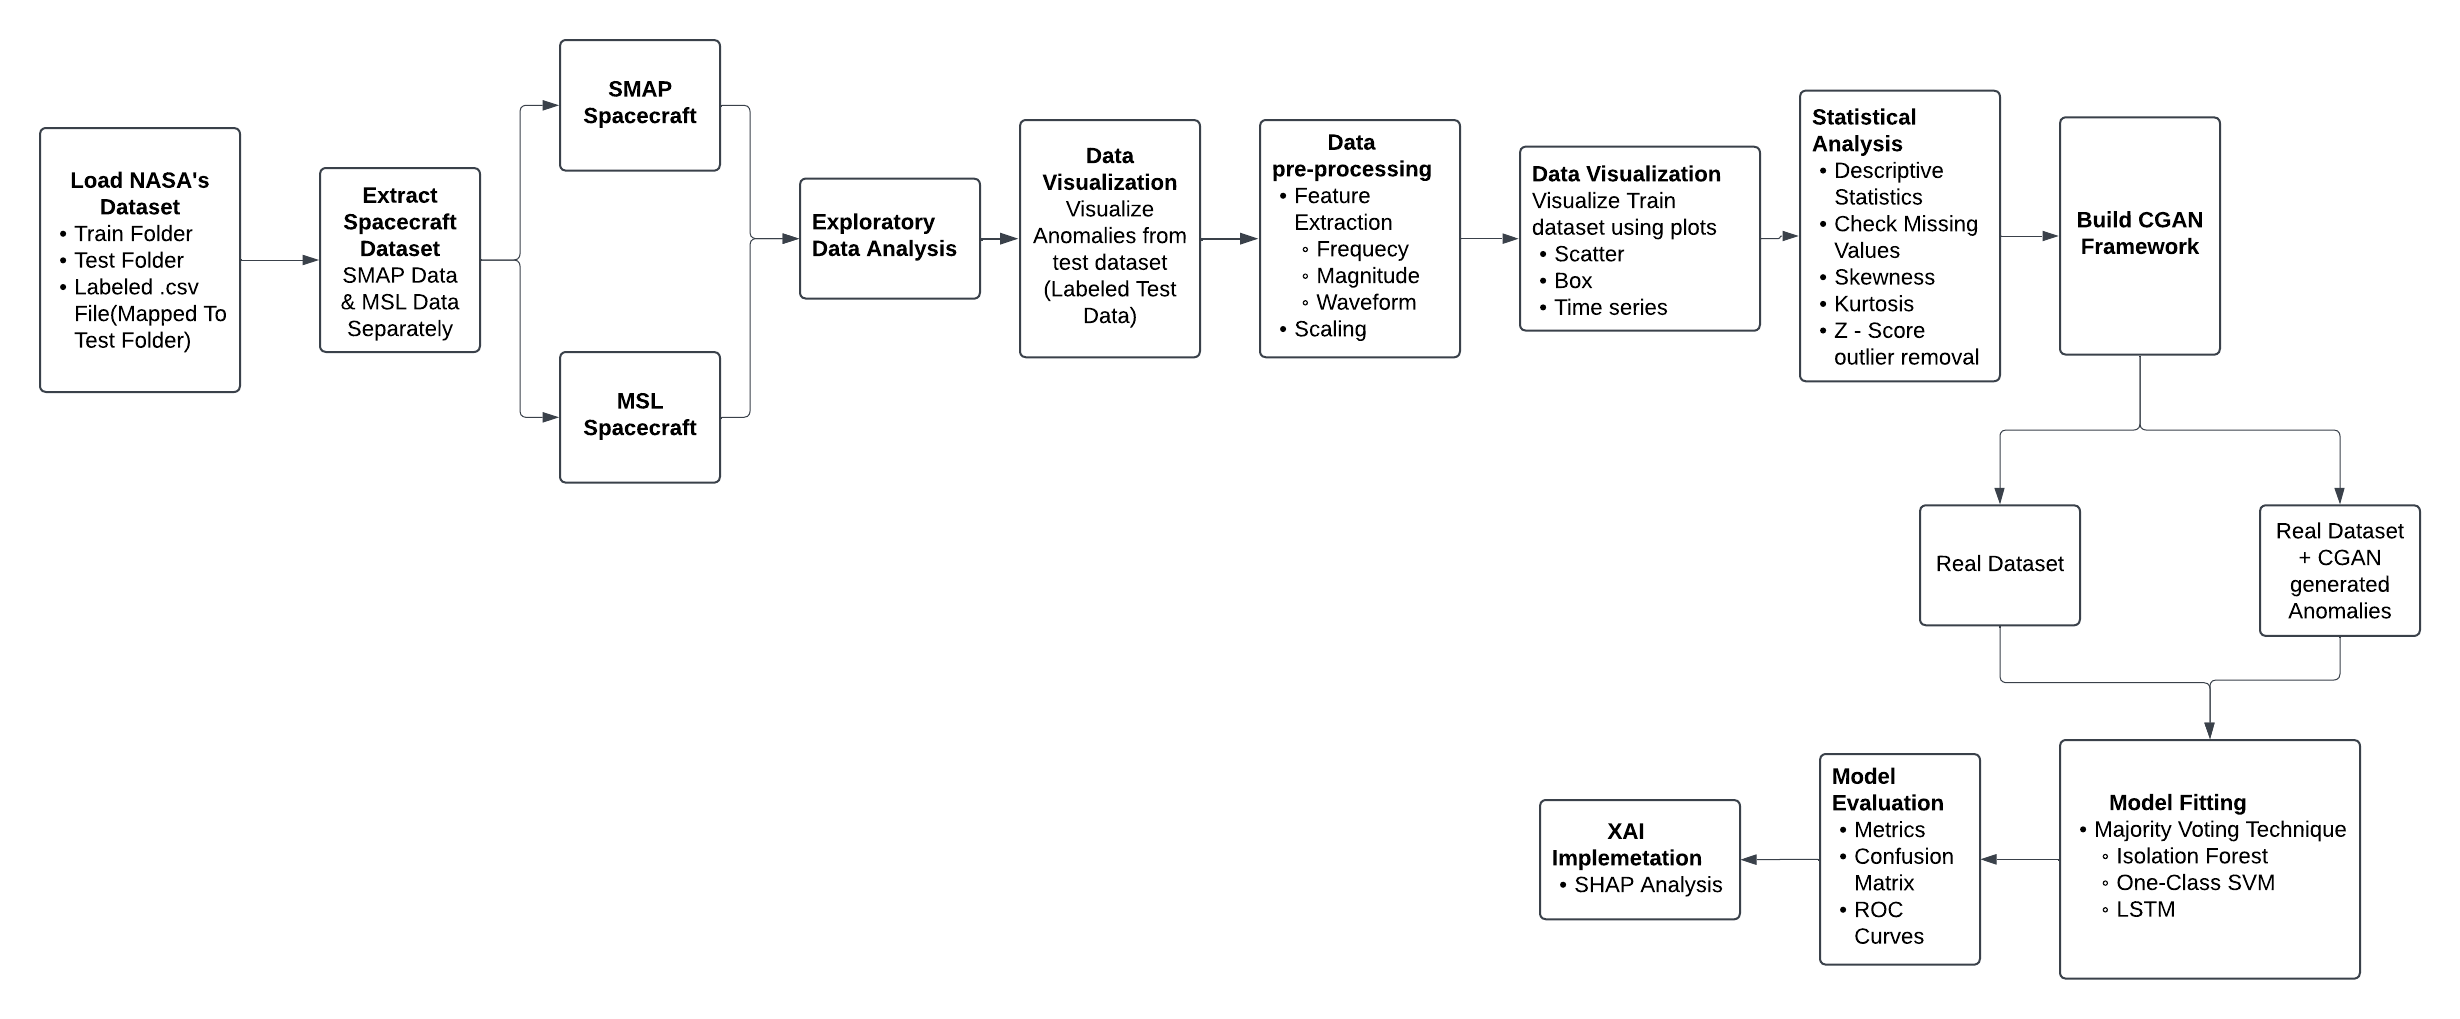

In [3]:
Image(filename='Anomaly_detection_Flowchart_2321248.png')

# Load Dataset

In [4]:
# Import telemetry data from train and test folders
data_train = '/Users/sukanyadas/Desktop/MS DS_Essex/Essex/Dissertation/POC/archive/data/data/train' 
data_test  = '/Users/sukanyadas/Desktop/MS DS_Essex/Essex/Dissertation/POC/archive/data/data/test'    

# Get the labeled anomalies file (belongs to Test)
labeled_anomalies_data = pd.read_csv('labeled_anomalies.csv')

In [5]:
labeled_anomalies_data.head(6)

,chan_id,spacecraft,anomaly_sequences,class,num_values
0,P-1,SMAP,"[[2149, 2349], [4536, 4844], [3539, 3779]]","[contextual, contextual, contextual]",8505
1,S-1,SMAP,"[[5300, 5747]]",[point],7331
2,E-1,SMAP,"[[5000, 5030], [5610, 6086]]","[contextual, contextual]",8516
3,E-2,SMAP,"[[5598, 6995]]",[point],8532
4,E-3,SMAP,"[[5094, 8306]]",[point],8307
5,E-4,SMAP,"[[5450, 8261]]",[point],8354


# Extract Telemetry Data (.npy files)

In [6]:
# Extract .npy files data using folder path (Train & Test)
def get_npy_files(folder):
    file_npy = [file for file in os.listdir(folder) if file.endswith('.npy')]
    telemetry_data = [np.load(os.path.join(folder, file)) for file in file_npy]
    return telemetry_data, file_npy

# Get data for training
train_telemetry_data, train_telemetry_files = get_npy_files(data_train)

# Get data for testing
test_telemetry_data, test_telemetry_files = get_npy_files(data_test)

# Exploratory Data Analysis 

In [7]:
telemetry_series = pd.Series(train_telemetry_data)

telemetry_series.isnull().sum()

0

In [8]:
telemetry_series.describe()

count                                                    82
unique                                                   82
top       [[0.4509818197145634, 0.0, 0.0, 0.0, 0.0, 0.0,...
freq                                                      1
dtype: object

# Separate SMAP and MSL (Test set labeled anomalies)

In [9]:
# Separate the labeled anomalies data into SMAP and MSL
smap_dataset = labeled_anomalies_data[labeled_anomalies_data['spacecraft'] == 'SMAP']
msl_dataset = labeled_anomalies_data[labeled_anomalies_data['spacecraft'] == 'MSL']

In [10]:
smap_dataset

,chan_id,spacecraft,anomaly_sequences,class,num_values
0,P-1,SMAP,"[[2149, 2349], [4536, 4844], [3539, 3779]]","[contextual, contextual, contextual]",8505
1,S-1,SMAP,"[[5300, 5747]]",[point],7331
2,E-1,SMAP,"[[5000, 5030], [5610, 6086]]","[contextual, contextual]",8516
3,E-2,SMAP,"[[5598, 6995]]",[point],8532
4,E-3,SMAP,"[[5094, 8306]]",[point],8307
5,E-4,SMAP,"[[5450, 8261]]",[point],8354
6,E-5,SMAP,"[[5600, 5920]]",[point],8294
7,E-6,SMAP,"[[5610, 5675]]",[point],8300
8,E-7,SMAP,"[[5394, 5674]]",[point],8310
9,E-8,SMAP,"[[5400, 6022]]",[point],8532


In [11]:
msl_dataset

,chan_id,spacecraft,anomaly_sequences,class,num_values
55,M-6,MSL,"[[1850, 2030]]",[point],2049
56,M-1,MSL,"[[1110, 2250]]",[contextual],2277
57,M-2,MSL,"[[1110, 2250]]",[contextual],2277
58,S-2,MSL,"[[900, 910]]",[point],1827
59,P-10,MSL,"[[4590, 4720]]",[point],6100
60,T-4,MSL,"[[1172, 1240]]",[point],2217
61,T-5,MSL,"[[1200, 1225]]",[point],2218
62,F-7,MSL,"[[1250, 1450], [2670, 2790], [3325, 3425]]","[contextual, contextual, contextual]",5054
63,M-3,MSL,"[[1250, 1500]]",[contextual],2127
64,M-4,MSL,"[[1250, 1500]]",[contextual],2038


# Map Specific Channel ID - Filename

In [12]:
# Function to map channel IDs to filenames
def map_channel_id_file(channel_id, file):
    for file_name in file:
        if channel_id in file_name:
            return file_name
    return None

# Get Anomalies (SMAP Test Set Channel - 1)

In [13]:
# Get one channel to visualize the anomalies from SMAP test set, as we don't have labeled anomalies in train set 
smap_channel_data = smap_dataset.iloc[0] 

# Extract channel ID and anomaly sequences
smap_channel_id = smap_channel_data['chan_id']
smap_anomaly_seq = eval(smap_channel_data['anomaly_sequences'])
smap_num_val = smap_channel_data['num_values']

print(f"Channel ID: {smap_channel_id}, Anomaly Seq: {smap_anomaly_seq}, Num Values: {smap_num_val}\n")

Channel ID: P-1, Anomaly Seq: [[2149, 2349], [4536, 4844], [3539, 3779]], Num Values: 8505



# Data Visualization (SMAP Test Set Channel - 1)

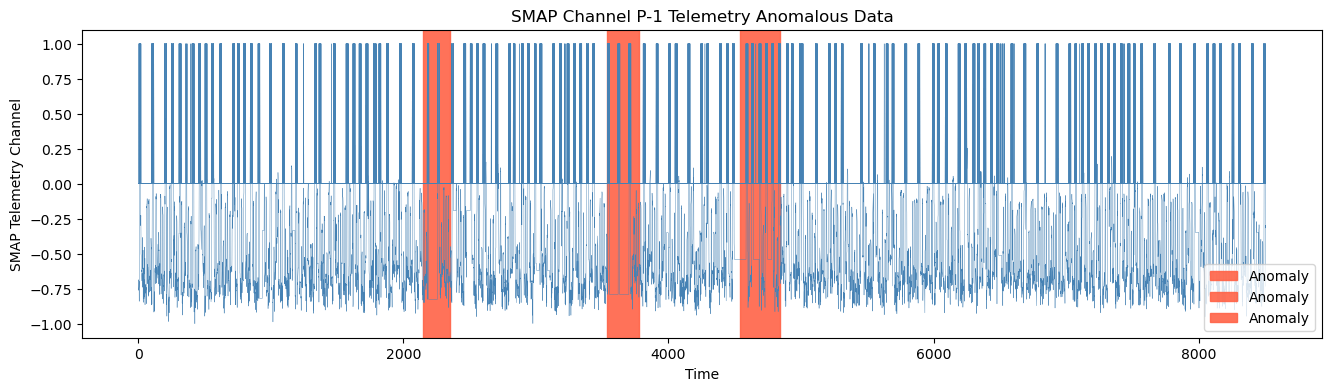

In [14]:
# Map the channel ID to the test file as anomalies are in test dataset
smap_file = map_channel_id_file(smap_channel_id, test_telemetry_files)

if smap_file:
# Get the telemetry data
    smap_telemetry_data = np.load(os.path.join(data_test, smap_file))
else:
    print("Channel ID not found.")

# Plot the entire telemetry data for the channel
plt.figure(figsize=(16, 4))
plt.plot(smap_telemetry_data,color='steelblue',linewidth=0.3)

# Highlight anomalies
for start, end in smap_anomaly_seq:
    plt.axvspan(start, end, color='tomato', alpha=0.9, label='Anomaly')

# Define labels
plt.title(f'SMAP Channel {smap_channel_id} Telemetry Anomalous Data')
plt.xlabel('Time')
plt.ylabel('SMAP Telemetry Channel')
plt.legend()
plt.show()

# Get Anomalies (MSL Test Set Channel - 8)

In [15]:
# Get MSL channel from the labeled anomalies (belongs to test set)
msl_channel_data = msl_dataset.iloc[7] 

# Extract channel ID and anomaly sequences
msl_channel_id = msl_channel_data['chan_id']
msl_anomaly_seq = eval(msl_channel_data['anomaly_sequences'])
msl_num_val = msl_channel_data['num_values']

print(f"Channel ID: {msl_channel_id}, Anomaly Seq: {msl_anomaly_seq}, Num Values: {msl_num_val}\n")

Channel ID: F-7, Anomaly Seq: [[1250, 1450], [2670, 2790], [3325, 3425]], Num Values: 5054



# Data Visualization (MSL Test Set Channel - 8)

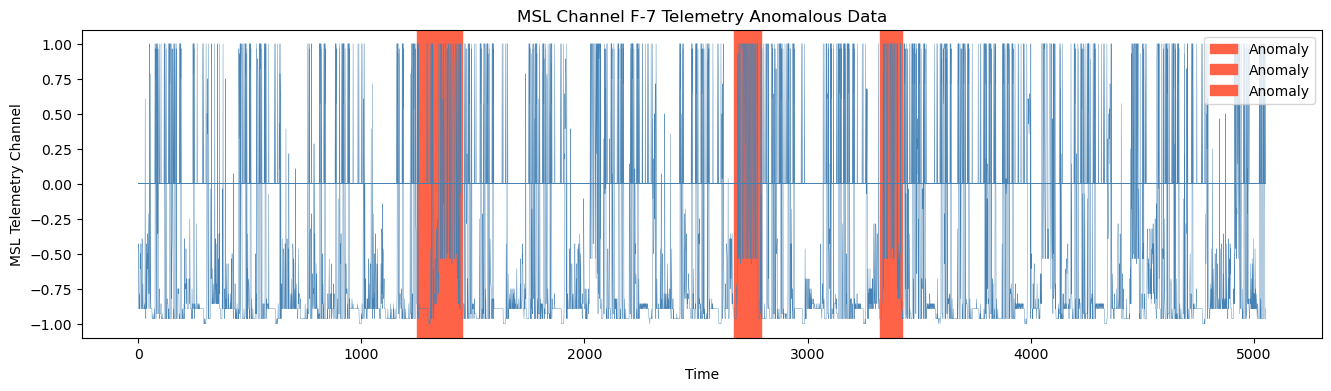

In [16]:
# Map the channel ID to the test file as anomalies are in test dataset
msl_file = map_channel_id_file(msl_channel_id, test_telemetry_files)

if msl_file:
# Get the telemetry data
    msl_telemetry_data = np.load(os.path.join(data_test, msl_file))
else:
    print("Channel ID not found.")

# Plot the entire telemetry data for the channel
plt.figure(figsize=(16, 4))
plt.plot(msl_telemetry_data,color='steelblue',linewidth=0.3)

# Highlight anomalies
for start, end in msl_anomaly_seq:
    plt.axvspan(start, end, color='tomato', alpha=1.0, label='Anomaly')

# Define Labels
plt.title(f'MSL Channel {msl_channel_id} Telemetry Anomalous Data')
plt.xlabel('Time')
plt.ylabel('MSL Telemetry Channel')
plt.legend()
plt.show()

# Feature Extraction

In [17]:
# Extract features from telemetry windows
def extract_telemetry_features(telemetry_data_window):
    if telemetry_data_window.ndim > 1:
        telemetry_data_window = telemetry_data_window.flatten()

    # Waveform
    windw = 5  # MA window size
    predicted_data = np.convolve(telemetry_data_window, np.ones(windw) / windw, mode='valid')
    actual_data = telemetry_data_window[windw - 1:]
    error = actual_data - predicted_data
    W = np.std(error)

    # Frequency
    _, _, x = stft(telemetry_data_window, nperseg=len(telemetry_data_window))
    summed_components = np.sum(np.abs(x), axis=0)
    F = np.std(summed_components)

    # Magnitude
    a = 0.3  
    smoothed_err = []
    for i, e in enumerate(error):
        smoothed_err.append(a * e + (1 - a) * smoothed_err[i - 1] if i > 0 else e)
    M = np.mean(smoothed_err)
    
    return [W, F, M]

# Get sliding windows
def get_sliding_windows(telemetry, window=100, step=50):
    windows = []
    for w in range(0, len(telemetry) - window + 1, step):
        windows.append(telemetry[w:w + window])
    return np.array(windows)


# Get all channels and extract features for train data processing
def train_channels_data_processing (channel_data, folder, files):
# Store all channels features
    telemetry_features = [] 

    for index, row in channel_data.iterrows():
        chan_id = row['chan_id']
        
        # Map the channel ID to the telemetry file
        filename = map_channel_id_file(chan_id, files)
        if filename:
            # Load the telemetry data
            telemetry_data = np.load(os.path.join(folder, filename))

            
            all_channel_ft = []  # Clear for each channel
            
            # Split data into sliding windows and extract features
            windows = get_sliding_windows(telemetry_data, window=100, step=50)
            for window in windows:
                features = extract_telemetry_features(window)
                all_channel_ft.append(features)
            
            # Convert features to numpy array for the current channel
            all_channel_ft = np.array(all_channel_ft)

            # Append the features of the channel to the main list
            telemetry_features.append(all_channel_ft)
    
    # Flatten the list of all features
    telemetry_features = np.concatenate(telemetry_features, axis=0)

    return telemetry_features

# Get all channels and extract features for test data processing
def test_channels_data_processing(channel_data, folder, files):
# Store all channels features
    telemetry_features = []  
# To store all labels for anomalies
    telemetry_labels = []   

    for index, row in channel_data.iterrows():
        chan_id = row['chan_id']
        anomaly_sequences = eval(row['anomaly_sequences']) 
        
        # Map the channel ID to the telemetry file
        filename = map_channel_id_file(chan_id, files)
        if filename:
            # Load the telemetry data
            telemetry_data = np.load(os.path.join(folder, filename))

            # clear all_channel_features and all_channel_labels 
            all_channel_ft = [] 
            all_channel_lb = []   
            
            # Split data into sliding windows and extract features
            windows = get_sliding_windows(telemetry_data, window=100, step=50)
            for window_idx, window in enumerate(windows):
                features = extract_telemetry_features(window)
                all_channel_ft.append(features)

                # Label each window based on whether it overlaps with an anomaly
                window_start = window_idx * len(window)
                window_end = window_start + len(window) - 1
                label = 0
                for start, end in anomaly_sequences:
                    if (window_start <= end) and (window_end >= start):
                        label = 1
                        break
                all_channel_lb.append(label)
            
            # Convert features and labels to numpy arrays for the current channel
            all_channel_ft = np.array(all_channel_ft)
            all_channel_lb = np.array(all_channel_lb)

            # Append the features and labels of the channel to the main list
            telemetry_features.append(all_channel_ft)
            telemetry_labels.append(all_channel_lb)
    
    # Flatten the list of telemetry features and labels
    telemetry_features = np.concatenate(telemetry_features, axis=0)
    telemetry_labels = np.concatenate(telemetry_labels, axis=0)

    return telemetry_features, telemetry_labels

In [18]:
# Process SMAP for both train and test set
smap_feature_train = train_channels_data_processing(smap_dataset, data_train, train_telemetry_files)
smap_feature_test, smap_label_test_data = test_channels_data_processing(smap_dataset, data_test, test_telemetry_files)

In [19]:
# Process MSL for both train and test set
msl_feature_train = train_channels_data_processing(msl_dataset, data_train, train_telemetry_files)
msl_feature_test, msl_label_test_data = test_channels_data_processing(msl_dataset, data_test,test_telemetry_files)

# Scaling SMAP & MSL Data

In [20]:
# Normalize the extracted features for train and test set
scaler = MinMaxScaler(feature_range=(0, 1))

In [21]:
# Scale SMAP set
smap_feature_train_data = scaler.fit_transform(smap_feature_train)
smap_feature_test_data = scaler.transform(smap_feature_test)

In [22]:
# Scale MSL set
msl_feature_train_data = scaler.fit_transform(msl_feature_train)
msl_feature_test_data = scaler.transform(msl_feature_test)

In [23]:
print(smap_feature_train_data)

[[0.58461328 0.6635556  0.72702385]
 [0.57449499 0.47049964 0.76521356]
 [0.57126802 0.54265938 0.73392399]
 ...
 [0.72171571 0.3536357  0.51710163]
 [0.84136531 0.5563291  0.51175621]
 [0.85295212 0.22529912 0.50641079]]


In [24]:
print(smap_feature_test_data) 

[[0.5807986  0.63356027 0.75350239]
 [0.56516709 0.6965475  0.72852042]
 [0.56391823 0.6514912  0.71653575]
 ...
 [0.67477827 0.17651807 0.50063423]
 [0.68291881 0.17864923 0.49885279]
 [0.69105936 0.18078043 0.49707135]]


In [25]:
print(msl_feature_train_data)

[[0.35718738 0.13217419 0.90781413]
 [0.35290144 0.13257306 0.90781408]
 [0.35290144 0.1839455  0.90781408]
 ...
 [0.31207371 0.16100235 0.53925467]
 [0.30889968 0.0968296  0.90781408]
 [0.27942189 0.15811733 0.89245744]]


In [26]:
print(msl_feature_test_data)

[[0.34794197 0.09146913 0.90781408]
 [0.35302458 0.18491684 0.90781408]
 [0.3592516  0.12791602 0.90781408]
 ...
 [0.2877314  0.03955527 0.89245744]
 [0.30069651 0.08474811 0.90781408]
 [0.31719318 0.14269112 0.90013576]]


# Data Visualization (SMAP Train Set)

In [27]:
spacecraft_features = ["Waveform", "Frequency", "Magnitude"]

In [28]:
print("SMAP dataset shape:", smap_feature_train_data.shape)

smap_train_dataframe = pd.DataFrame(smap_feature_train_data, columns=spacecraft_features)

SMAP dataset shape: (2719, 3)


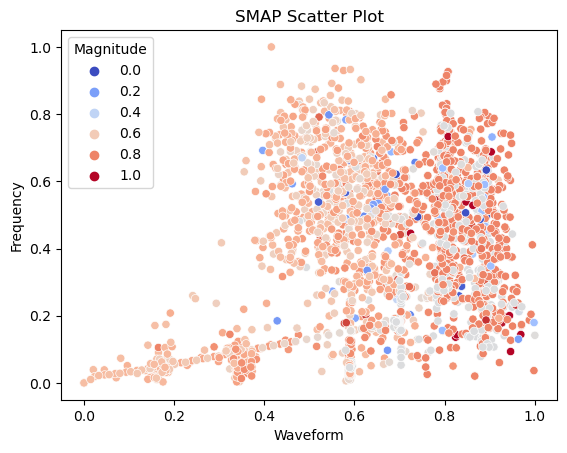

In [29]:
# Scatter Plot
sns.scatterplot(data=smap_train_dataframe, x="Waveform", y="Frequency", hue="Magnitude", palette="coolwarm")

# Show plot
plt.title("SMAP Scatter Plot",fontsize=12)
plt.xlabel("Waveform")
plt.ylabel("Frequency")
plt.show()

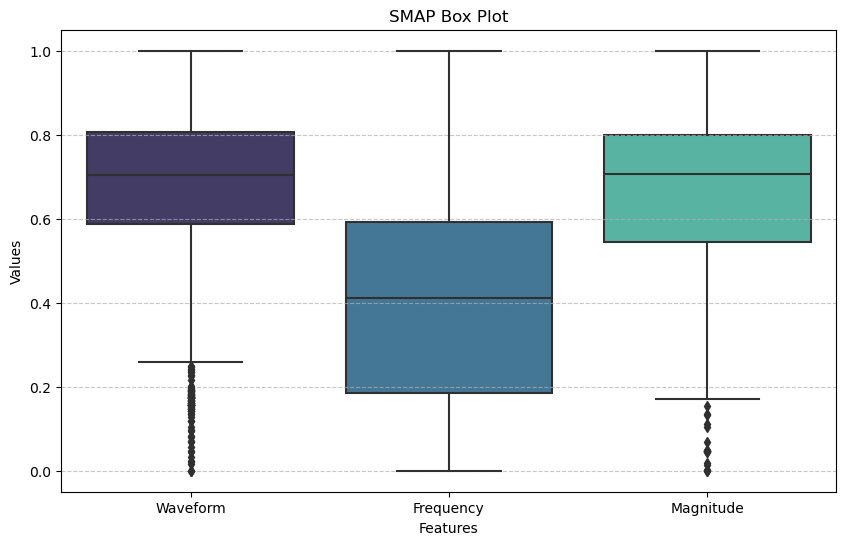

In [30]:
# Box plot 
plt.figure(figsize=(10, 6))
palette = sns.color_palette("mako", len(smap_train_dataframe.columns))  
sns.boxplot(data=smap_train_dataframe, palette=palette)

# Show plot
plt.title("SMAP Box Plot", fontsize=12)
plt.xlabel("Features", fontsize=10)
plt.ylabel("Values", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7) 
plt.show()

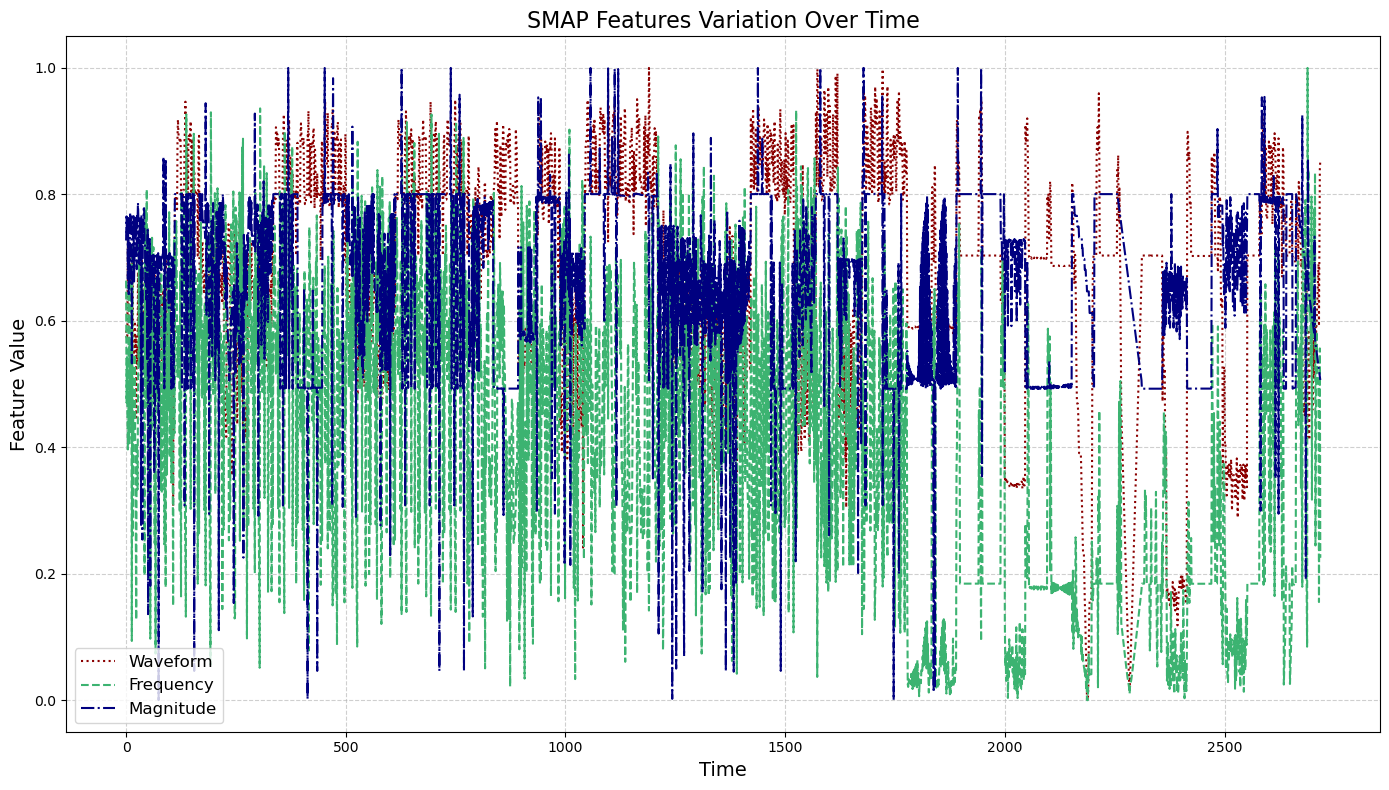

In [31]:
# Time series plot
plt.figure(figsize=(14, 8))

# Each feature with different colors
colors = ["darkred", "mediumseagreen", "navy"] 
styles = [":", "--", "-."] 

for i, (feature, color, line) in enumerate(zip(spacecraft_features, colors, styles)):
    plt.plot(smap_feature_train_data[:, i], label=feature, color=color, linestyle=line, linewidth=1.5)

# Show plot
plt.title("SMAP Features Variation Over Time", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Feature Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Statistical Analysis (SMAP Train Set)

In [32]:
# SMAP Descriptive statistics
print("SMAP Train Set Summary:")
print(smap_train_dataframe.describe())

print(" ")

# Verify any missing values
print("SMAP Train Set Missing Values:")
print(smap_train_dataframe.isnull().sum())

SMAP Train Set Summary:
          Waveform    Frequency    Magnitude
count  2719.000000  2719.000000  2719.000000
mean      0.678791     0.398752     0.671090
std       0.179688     0.230543     0.143738
min       0.000000     0.000000     0.000000
25%       0.587722     0.184250     0.544881
50%       0.703259     0.411121     0.706364
75%       0.807377     0.591301     0.800406
max       1.000000     1.000000     1.000000
 
SMAP Train Set Missing Values:
Waveform     0
Frequency    0
Magnitude    0
dtype: int64


In [33]:
print("SMAP Train Set Skewness:")
print(smap_train_dataframe.skew())

print(" ")

print("\nSMAP Train Set Kurtosis:")
print(smap_train_dataframe.kurtosis())

SMAP Train Set Skewness:
Waveform    -0.970564
Frequency    0.036347
Magnitude   -1.023466
dtype: float64
 

SMAP Train Set Kurtosis:
Waveform     0.931676
Frequency   -1.181099
Magnitude    1.641451
dtype: float64


In [34]:
# SMAP Z-scores for each feature
smap_z_scores = np.abs(zscore(smap_train_dataframe))

# Threshold
threshold = 3
outliers = (smap_z_scores > threshold)

# Outliers
print("SMAP: Number of Outliers per Feature (Z-score):")
print(outliers.sum(axis=0))

SMAP: Number of Outliers per Feature (Z-score):
Waveform     22
Frequency     0
Magnitude    36
dtype: int64


In [35]:
# Remove outliers
smap_train_cleaned = smap_train_dataframe[(smap_z_scores <= threshold).all(axis=1)]
smap_train_cleaned
smap_feature_train_df = smap_train_cleaned
smap_feature_train_data = smap_feature_train_df.to_numpy()
smap_feature_train_data

array([[0.58461328, 0.6635556 , 0.72702385],
       [0.57449499, 0.47049964, 0.76521356],
       [0.57126802, 0.54265938, 0.73392399],
       ...,
       [0.72171571, 0.3536357 , 0.51710163],
       [0.84136531, 0.5563291 , 0.51175621],
       [0.85295212, 0.22529912, 0.50641079]])

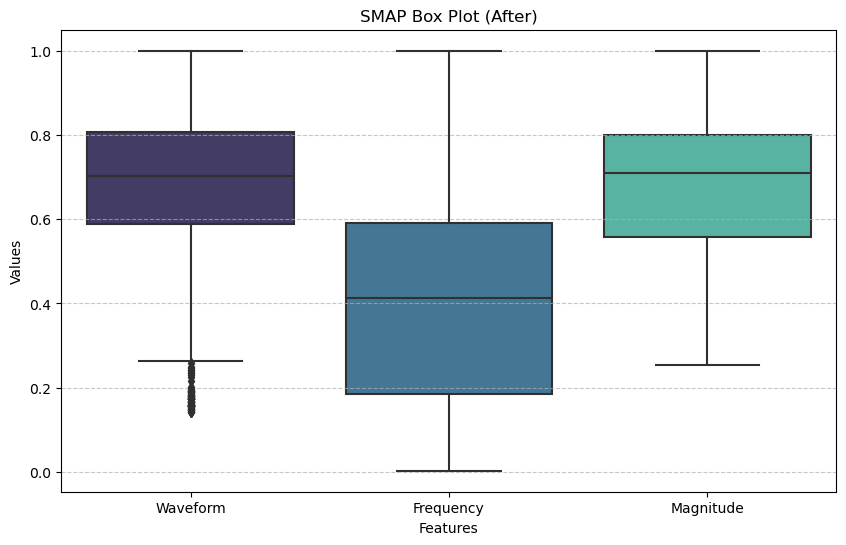

In [36]:
# Box plot 
smap_train_df_upd = pd.DataFrame(smap_feature_train_data, columns=spacecraft_features)

plt.figure(figsize=(10, 6))
palette = sns.color_palette("mako", len(smap_train_df_upd.columns)) 
sns.boxplot(data=smap_train_df_upd, palette=palette)

# Show plot
plt.title("SMAP Box Plot (After)", fontsize=12)
plt.xlabel("Features", fontsize=10)
plt.ylabel("Values", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Data Visualization (MSL Train Set)

In [37]:
print("MSL dataset shape:", msl_feature_train_data.shape)

msl_train_dataframe = pd.DataFrame(msl_feature_train_data, columns=spacecraft_features)

MSL dataset shape: (1125, 3)


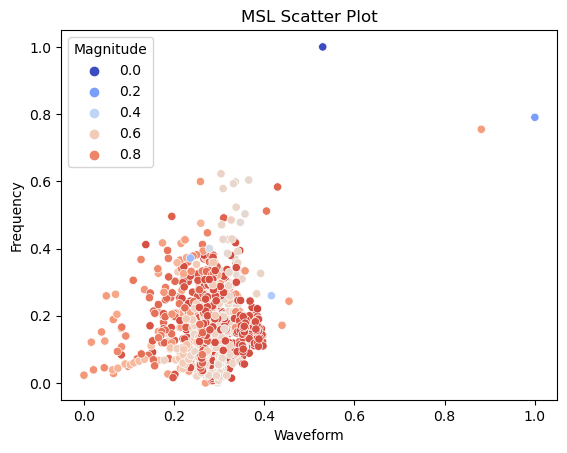

In [38]:
# Scatter Plot
sns.scatterplot(data=msl_train_dataframe, x="Waveform", y="Frequency", hue="Magnitude", palette="coolwarm")

# Show plot
plt.title("MSL Scatter Plot",fontsize=12)
plt.xlabel("Waveform")
plt.ylabel("Frequency")
plt.show()

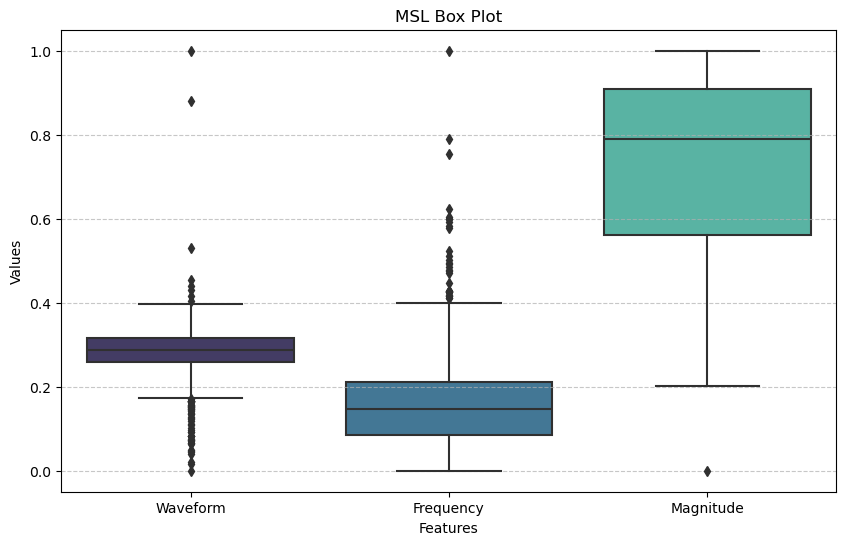

In [39]:
# Box plot 
plt.figure(figsize=(10, 6))
palette = sns.color_palette("mako", len(msl_train_dataframe.columns)) 
sns.boxplot(data=msl_train_dataframe, palette=palette)

# Show plot
plt.title("MSL Box Plot", fontsize=12)
plt.xlabel("Features", fontsize=10)
plt.ylabel("Values", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

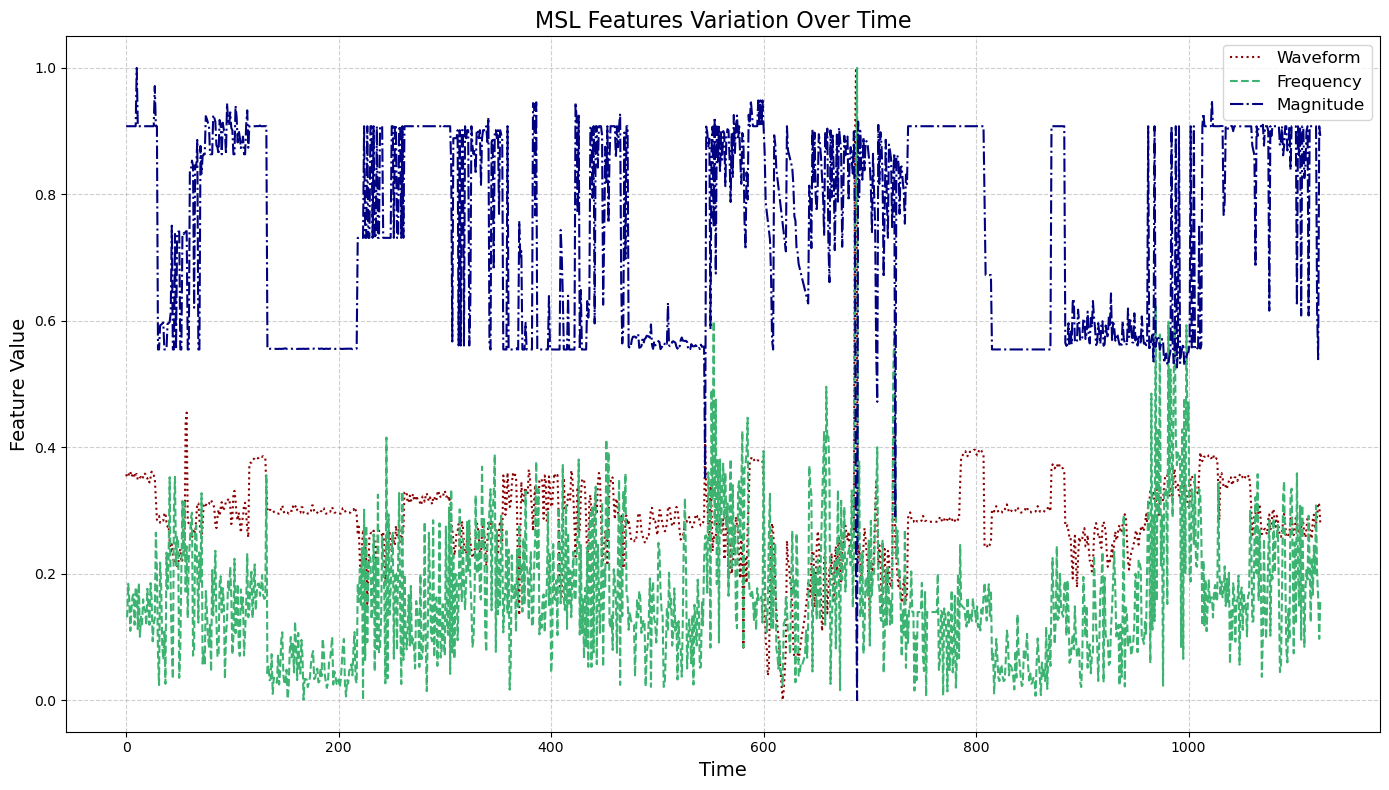

In [40]:
# Time series plot
plt.figure(figsize=(14, 8))

# Each feature with different colors
colors = ["darkred", "mediumseagreen", "navy"] 
styles = [":", "--", "-."] 
    
for i, (feature, color, line) in enumerate(zip(spacecraft_features, colors, styles)):
    plt.plot(msl_feature_train_data[:, i], label=feature, color=color, linestyle=line, linewidth=1.5)

# Show plot
plt.title("MSL Features Variation Over Time", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Feature Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Statistical Analysis (MSL Train Set)

In [41]:
# SMAP Descriptive statistics
print("MSL Train Set Summary:")
print(msl_train_dataframe.describe())

print(" ")

# Verify any missing values
print("MSL Train Set Missing Values:")
print(msl_train_dataframe.isnull().sum())

MSL Train Set Summary:
          Waveform    Frequency    Magnitude
count  1125.000000  1125.000000  1125.000000
mean      0.285679     0.164076     0.743871
std       0.067167     0.109415     0.161023
min       0.000000     0.000000     0.000000
25%       0.258754     0.085318     0.560480
50%       0.288448     0.146506     0.790079
75%       0.316651     0.211309     0.907814
max       1.000000     1.000000     1.000000
 
MSL Train Set Missing Values:
Waveform     0
Frequency    0
Magnitude    0
dtype: int64


In [42]:
print("MSL Train Set Skewness:")
print(msl_train_dataframe.skew())

print(" ")

print("\nMSL Train Set Kurtosis:")
print(msl_train_dataframe.kurtosis())

MSL Train Set Skewness:
Waveform     0.952926
Frequency    1.582325
Magnitude   -0.278537
dtype: float64
 

MSL Train Set Kurtosis:
Waveform     17.938710
Frequency     5.431802
Magnitude    -1.284081
dtype: float64


In [43]:
# MSL Z-scores for each feature
msl_z_scores = np.abs(zscore(msl_train_dataframe))

# Threshold
threshold = 3
outliers = (msl_z_scores > threshold)

# Outliers
print("MSL: Number of Outliers per Feature (Z-score):")
print(outliers.sum(axis=0))

MSL: Number of Outliers per Feature (Z-score):
Waveform     21
Frequency    14
Magnitude     2
dtype: int64


In [44]:
# Remove outliers
msl_train_cleaned = msl_train_dataframe[(msl_z_scores <= threshold).all(axis=1)]
msl_train_cleaned
msl_feature_train_df = msl_train_cleaned
msl_feature_train_data = msl_feature_train_df.to_numpy()
msl_feature_train_data

array([[0.35718738, 0.13217419, 0.90781413],
       [0.35290144, 0.13257306, 0.90781408],
       [0.35290144, 0.1839455 , 0.90781408],
       ...,
       [0.31207371, 0.16100235, 0.53925467],
       [0.30889968, 0.0968296 , 0.90781408],
       [0.27942189, 0.15811733, 0.89245744]])

In [45]:
msl_feature_train_data.shape

(1093, 3)

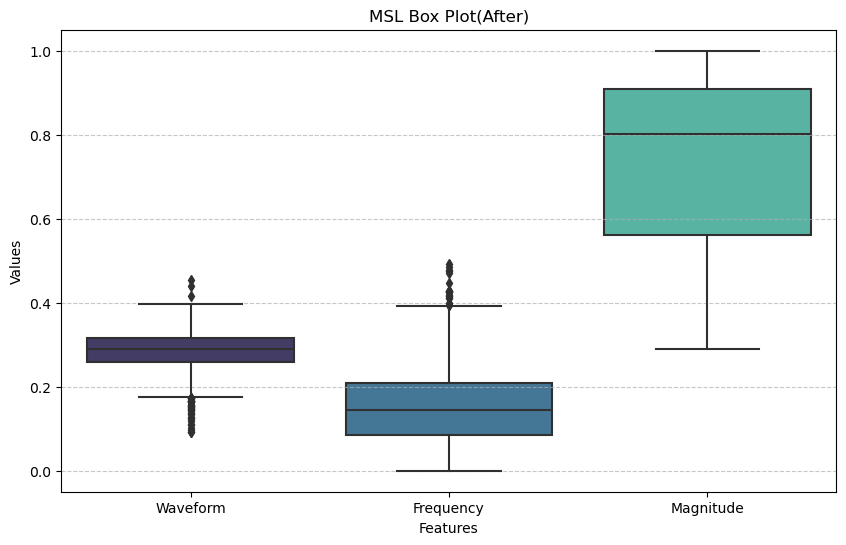

In [46]:
# Box plot 
msl_train_df_upd = pd.DataFrame(msl_feature_train_data, columns=spacecraft_features)

plt.figure(figsize=(10, 6))
palette = sns.color_palette("mako", len(msl_train_df_upd.columns)) 
sns.boxplot(data=msl_train_df_upd, palette=palette)

# Show plot
plt.title("MSL Box Plot(After)", fontsize=12)
plt.xlabel("Features", fontsize=10)
plt.ylabel("Values", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# CGAN Framework (Gen AI)

In [47]:
def build_generator_cgan(input_shape):
    noise_input = Input(shape=(input_shape[0], 1))  # Noise 
    condition_ip = Input(shape=(1,))  # Condition (normal=0, anomaly=1)

    # Pass the condition input through a dense layer and extend its dimensions to match the noise input
    condition_dense = Dense(input_shape[0], activation="relu")(condition_ip)
    condition_expanded = Reshape((input_shape[0], 1))(condition_dense)

    # Concatenate the noise and condition inputs
    concatenated_input = Concatenate()([noise_input, condition_expanded])

    # Generator LSTM layers 80 each
    layer = LSTM(80, return_sequences=True, kernel_regularizer=l2(0.00005))(concatenated_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.3)(layer)
    layer = BatchNormalization()(layer)

    layer = LSTM(80, return_sequences=False, kernel_regularizer=l2(0.00005))(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.3)(layer)
    layer = BatchNormalization()(layer)

    # Output setup
    output = Dense(input_shape[0])(layer)  
    output = Reshape((input_shape[0], 1))(output) 

    generator = Model(inputs=[noise_input, condition_ip], outputs=output)
    return generator

In [48]:
def build_discriminator_cgan(input_shape):
    data_input = Input(shape=(input_shape[0], 1))  # Telemetry data input
    condition_ip = Input(shape=(1,))  # Condition input

    # Pass the condition input through a dense layer and extend dimensions to match the data input
    condition_dense = Dense(input_shape[0], activation="relu")(condition_ip)
    condition_expanded = Reshape((input_shape[0], 1))(condition_dense)

    # Concatenate the data input with the condition input
    concatenated_input = Concatenate()([data_input, condition_expanded])

    # Discriminator LSTM layers 80 each
    layer = LSTM(80, return_sequences=True, kernel_regularizer=l2(0.00005))(concatenated_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.3)(layer)
    layer = BatchNormalization()(layer)

    layer = LSTM(80, return_sequences=False, kernel_regularizer=l2(0.00005))(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.3)(layer)
    layer = BatchNormalization()(layer)

    # Output layer for real/fake classification
    output = Dense(1, activation='sigmoid')(layer)

    discriminator = Model(inputs=[data_input, condition_ip], outputs=output)
    return discriminator

In [49]:
def build_cgan_framework(generator, discriminator):
   # Define optimizers
    g_optimiser = Adam(learning_rate=0.0005, beta_1=0.5)
    d_optimiser = Adam(learning_rate=0.0001, beta_1=0.5)

    discriminator.compile(optimizer=d_optimiser, loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False  # Freeze discriminator during CGAN training (not to train)

    # GAN input as noise and condition 
    noise_input = Input(shape=(input_shape[0], 1))  # Noise for generator
    condition_ip = Input(shape=(1,))  # Condition 0 for normal and 1 for anomalous

    # Generator to get synthetic data 
    generated_data = generator([noise_input, condition_ip])

    # Process
    gan_output = discriminator([generated_data, condition_ip])

    # Create the GAN model
    gan = Model(inputs=[noise_input, condition_ip], outputs=gan_output)
    gan.compile(optimizer=g_optimiser, loss='mean_squared_error')  

    return gan

# SMAP Set Up

# Test Data Counts

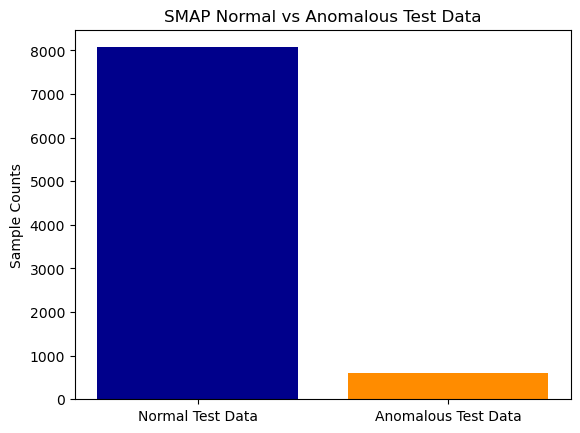

In [50]:
# Anomalies in the test set
normal_test_data = smap_feature_test_data[smap_label_test_data == 0]
anomalous_test_data = smap_feature_test_data[smap_label_test_data == 1]

normal_count = normal_test_data.shape[0]
anomaly_count = anomalous_test_data.shape[0]

# Show plot
categories = ['Normal Test Data', 'Anomalous Test Data']
counts = [normal_count, anomaly_count]

plt.bar(categories, counts, color=['darkblue', 'darkorange'])
plt.title('SMAP Normal vs Anomalous Test Data')
plt.ylabel('Sample Counts')
plt.show()

# CGAN - Train Model

In [51]:
# Input shape based on your training data's feature shape
input_shape = (smap_feature_train_data.shape[1], 1)

generator = build_generator_cgan(input_shape)
generator.summary()

discriminator = build_discriminator_cgan(input_shape)
discriminator.summary()

# Build GAN
gan = build_cgan_framework(generator, discriminator)
gan.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │          6 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 3, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 3, 1)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3, 2)      │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 3, 80)     │     26,560 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 3, 80)     │          0 │ lstm[0][0]        │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 3, 80)     │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 3, 80)     │        320 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 80)        │     51,520 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 80)        │          0 │ lstm_1[0][0]      │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 80)        │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80)        │        320 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        243 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 1)      │          0 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 78,969 (308.47 KB)

 Trainable params: 78,649 (307.22 KB)

 Non-trainable params: 320 (1.25 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │          6 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 3, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 3, 1)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 3, 2)      │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 3, 80)     │     26,560 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 3, 80)     │          0 │ lstm_2[0][0]      │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 3, 80)     │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 80)     │        320 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 80)        │     51,520 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 80)        │          0 │ lstm_3[0][0]      │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 80)        │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80)        │        320 │ dropout_3[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         81 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 78,807 (307.84 KB)

 Trainable params: 78,487 (306.59 KB)

 Non-trainable params: 320 (1.25 KB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 3, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 3, 1)      │     78,969 │ input_layer_4[0]… │
│ (Functional)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 1)         │     78,807 │ functional[0][0], │
│ (Functional)        │                   │            │ input_layer_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 157,776 (616.31 KB)

 Trainable params: 78,649 (307.22 KB)

 Non-trainable params: 79,127 (309.09 KB)

In [52]:
# Track losses
d_losses = []  # Discriminator losses
g_losses = []  # Generator losses

def smap_generate_synthetic_anomalies(data_sample, input_data):
    # Noise parameters to adjust mean and standard deviation
    shift_factor = 0.1 
    scale_factor = 0.8  
    
    # Generate noise with mean and standard deviation (main parameters)
    mean = 0 + shift_factor
    std = 1 * scale_factor
    
    np.random.seed(42)
    noise = np.random.normal(mean,std,(data_sample, input_data[0], 1))
    return generator.predict([noise, np.ones((data_sample, 1))])


def train_cgan_smap(generator, discriminator, gan, real_data, epochs, batch_size):

    shift_factor = 0.1  
    scale_factor = 0.8   

    half_batch_size = batch_size // 2

    for epoch in range(epochs):
        np.random.seed(42)  # Set the seed before the sampling 
        random_idx = np.random.randint(0, real_data.shape[0], half_batch_size)
        real_samples = real_data[random_idx].reshape(half_batch_size, real_data.shape[1], 1)
        real_labels = np.ones((half_batch_size, 1))  # Label normal data as 1
        real_conditions = np.zeros((half_batch_size, 1))  # Condition 0 for normal data

        # Generate synthetic anomalies 
        synthetic_samples = smap_generate_synthetic_anomalies(half_batch_size, real_data.shape[1:])
        synthetic_samples = scaler.transform(synthetic_samples.reshape(half_batch_size, -1)).reshape(half_batch_size, real_data.shape[1], 1)
        synthetic_labels = np.zeros((half_batch_size, 1))  # Label synthetic data as 0
        synthetic_conditions = np.ones((half_batch_size, 1))  # Condition 1 for synthetic anomalies

        # Discriminator training on both real and synthetic data
        loss_real_d = discriminator.train_on_batch([real_samples, real_conditions], real_labels)
        loss_fake_d = discriminator.train_on_batch([synthetic_samples, synthetic_conditions], synthetic_labels)
        loss_d = 0.5 * np.add(loss_real_d, loss_fake_d)

        # Generator training
        noise = np.random.normal(shift_factor, scale_factor, (batch_size, real_data.shape[1], 1))
        fake_labels = np.ones((batch_size, 1))  
        loss_g = gan.train_on_batch([noise, np.ones((batch_size, 1))], fake_labels)
        loss_avg_g = np.mean(loss_g)

        # Track losses and evaluation metrics
        d_losses.append(loss_d[0])
        g_losses.append(loss_avg_g)

        # Loss per 10 epochs 
        if epoch % 10 == 0:
            print(f"Loss per Epochs: {epoch}, D: {loss_d[0]}, G: {loss_g}")

    return d_losses, g_losses

In [53]:
start_time = time.time()

scaler = StandardScaler().fit(smap_feature_train_data)

# CGAN Training Settings
epochs = 100
batch_size = 32
half_batch_size = batch_size // 2

# Run the training function
smap_d_loss, smap_g_loss = train_cgan_smap(generator, discriminator, gan, smap_feature_train_data, epochs, batch_size)

end_time = time.time()

# CGAN training time
total_time = end_time - start_time

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Loss per Epochs: 0, D: 0.6878686547279358, G: [array(0.68816006, dtype=float32), array(0.68816006, dtype=float32), array(0.84375, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Loss per Epochs: 10, D: 0.6891391277313232, G: [array(0.68921363, dtype=float32), array(0.68921363, dtype=float32), array(0.75852275, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1

In [54]:
# Training time in seconds
print(f"SMAP CGAN training time: {total_time:.2f} seconds")

SMAP CGAN training time: 58.37 seconds


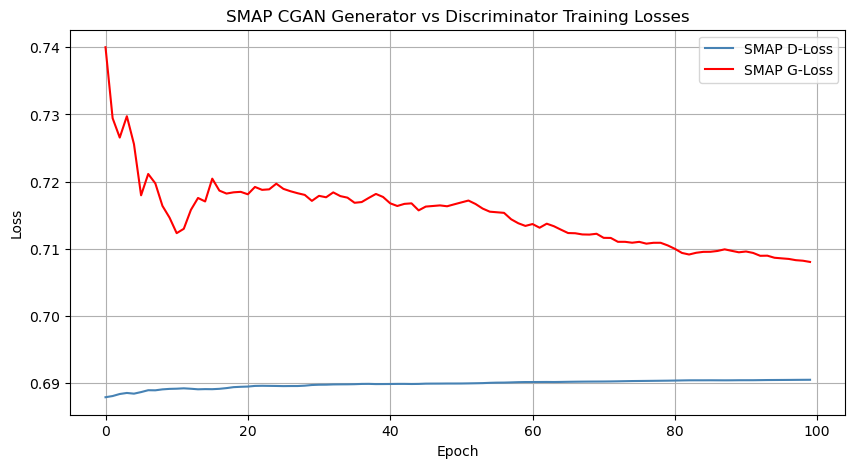

In [55]:
# Function to plot GAN losses
def plot_cgan_smap_losses(smap_d_loss, smap_g_loss, title):
    plt.figure(figsize=(10, 5))
    plt.plot(smap_d_loss, label="SMAP D-Loss", color='steelblue')
    plt.plot(smap_g_loss, label="SMAP G-Loss", color='red')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Show plot
plot_cgan_smap_losses(smap_d_loss, smap_g_loss, title="SMAP CGAN Generator vs Discriminator Training Losses")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


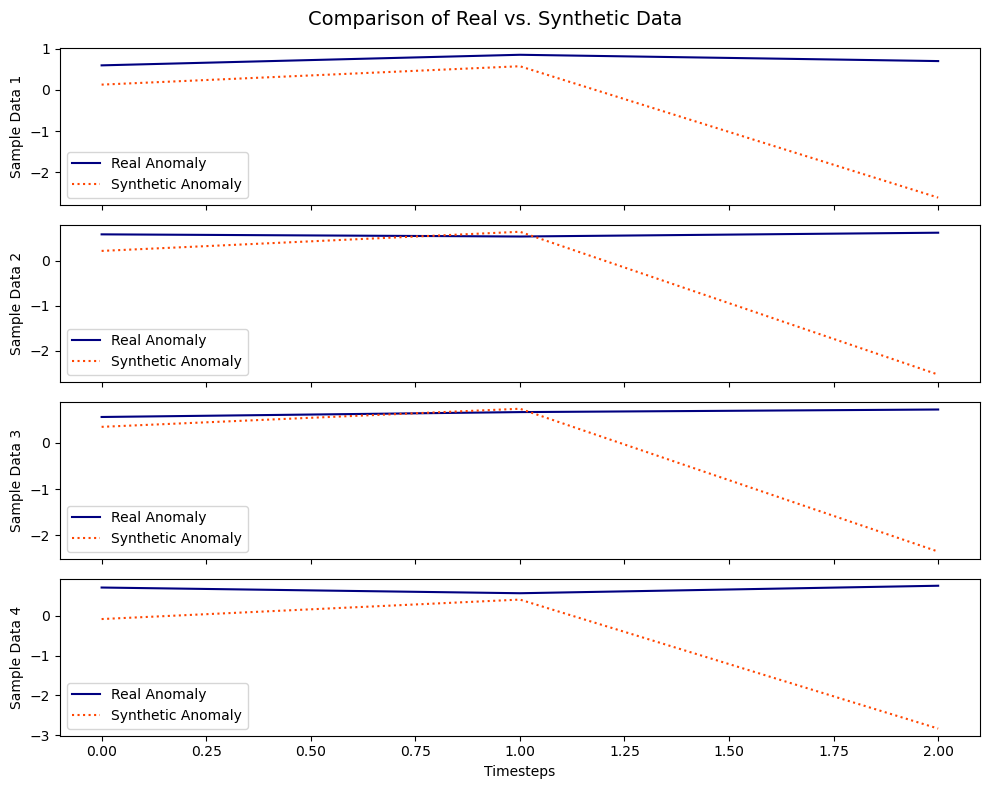

SMAP DTW Distance between Real and Synthetic Anomalies: 15.108293894283253


In [56]:
# Number of synthetic samples to generate for visualization
samples = 4 

# Generate synthetic anomalies and scale to match training data 
smap_synthetic_anomalies = smap_generate_synthetic_anomalies(samples, smap_feature_train_data.shape[1:])
smap_synthetic_anomalies_data = scaler.transform(smap_synthetic_anomalies.reshape(samples, -1)).reshape(samples, smap_feature_train_data.shape[1])

# Get real test set anomalies for comparison
test_anomalies_data = smap_feature_test_data[smap_label_test_data == 1]
sample_data = test_anomalies_data[:samples]

# Show plot
fig, axes = plt.subplots(samples, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Comparison of Real vs. Synthetic Data', fontsize=14)

for sample in range(samples):
    axes[sample].plot(sample_data[sample].flatten(), label="Real Anomaly", color="navy")
    axes[sample].plot(smap_synthetic_anomalies_data[sample].flatten(), label="Synthetic Anomaly", color="orangered", linestyle=":")
    axes[sample].legend()
    axes[sample].set_ylabel(f"Sample Data {sample+1}")

plt.xlabel("Timesteps")
plt.tight_layout()
plt.show()

# Calculate DTW for samples comparison
synthetic_data = smap_synthetic_anomalies_data.reshape(-1)
real_test_data = sample_data.reshape(-1)  

smap_dtw_distance, _ = fastdtw(real_test_data, synthetic_data)

print(f"SMAP DTW Distance between Real and Synthetic Anomalies: {smap_dtw_distance}")

# SMAP Real Data

In [57]:
# LSTM Autoencoder to capture temporal patterns
def build_lstm_ae(time_steps, features):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=(time_steps,features)))
    model.add(Dropout(0.4))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dropout(0.4))
    model.add(RepeatVector(time_steps))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(features)))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model


# Input shape
time_steps, features = 1, smap_feature_train_data.shape[1]

# Build the autoencoder 
lstm_ae = build_lstm_ae(time_steps, features)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
# Reshape data dimensions
smap_lstm_train_data = smap_feature_train_data.reshape(smap_feature_train_data.shape[0], time_steps, features)

# Fit the LSTM Autoencoder
history = lstm_ae.fit(smap_lstm_train_data, smap_lstm_train_data, epochs=50, batch_size=64, validation_split=0.1,verbose=1)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3991 - val_loss: 0.3588
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3891 - val_loss: 0.3483
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3773 - val_loss: 0.3348
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3618 - val_loss: 0.3163
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3391 - val_loss: 0.2884
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3043 - val_loss: 0.2448
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2503 - val_loss: 0.1792
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1694 - val_loss: 0.0973
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0879 - val_loss: 0.0427
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0519 - val_loss: 0.0311
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0469 - val_loss: 0.0289
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0468 - val_lo

In [59]:
smap_lstm_train_data

array([[[0.58461328, 0.6635556 , 0.72702385]],

       [[0.57449499, 0.47049964, 0.76521356]],

       [[0.57126802, 0.54265938, 0.73392399]],

       ...,

       [[0.72171571, 0.3536357 , 0.51710163]],

       [[0.84136531, 0.5563291 , 0.51175621]],

       [[0.85295212, 0.22529912, 0.50641079]]])

In [60]:
# Get reconstruction errors on the training set
smap_train_predict = lstm_ae.predict(smap_lstm_train_data)
smap_train_mse = np.mean(np.square(smap_lstm_train_data - smap_train_predict), axis=(1, 2))

# Set the threshold percentile of training errors
smap_lstm_threshold = np.percentile(smap_train_mse, 85)

print("Train mse:", smap_train_mse)
print("Anomaly Detection Threshold:", smap_lstm_threshold)

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train mse: [0.01354617 0.00841704 0.00850297 ... 0.00588416 0.01959472 0.02302812]
Anomaly Detection Threshold: 0.02751670449216013


In [61]:
smap_train_predict

array([[[0.67802125, 0.4945738 , 0.66907024]],

       [[0.6484049 , 0.4167802 , 0.6352033 ]],

       [[0.653096  , 0.44110906, 0.6417251 ]],

       ...,

       [[0.617572  , 0.35824773, 0.59947455]],

       [[0.68906033, 0.45388418, 0.670162  ]],

       [[0.63393617, 0.32776555, 0.6094497 ]]], dtype=float32)

In [62]:
# Reshape the testset for LSTM
smap_lstm_test_data = smap_feature_test_data.reshape(smap_feature_test_data.shape[0], time_steps,features)

print("Test Data Shape:", smap_lstm_test_data.shape)

# Predict on the balanced test set
smap_test_predict = lstm_ae.predict(smap_lstm_test_data)

Test Data Shape: (8673, 1, 3)
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step


In [63]:
smap_feature_train_data.shape

(2661, 3)

In [64]:
smap_feature_test_data.shape

(8673, 3)

In [65]:
# Train IF 
isolation_forest = IsolationForest(contamination=0.01, max_samples=0.25,random_state=42)
isolation_forest.fit(smap_feature_train_data)

# Train OCSVM 
one_class_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.33)
one_class_svm.fit(smap_feature_train_data)

# Get LSTM reconstruction errors 
smap_lstm_test_mse = np.mean(np.square(smap_lstm_test_data - smap_test_predict), axis=(1, 2))
# Get predictions from the LSTM Autoencoder
smap_lstm_test_predictions = [1 if error > smap_lstm_threshold else 0 for error in smap_lstm_test_mse]

# Get predictions from the Isolation Forest
smap_iforest_test_predict = isolation_forest.predict(smap_feature_test_data)
# Convert Isolation Forest output (-1 for anomaly, 1 for normal) to 0 and 1
smap_iforest_test_predictions = [0 if if_pred == -1 else 1 for if_pred in smap_iforest_test_predict]

# Get predictions from the One-Class SVM
smap_svm_test_predict = one_class_svm.predict(smap_feature_test_data)
# Convert One-Class SVM output (-1 for anomaly, 1 for normal) to 0 and 1
smap_svm_test_predictions = [0 if oc_pred == -1 else 1 for oc_pred in smap_svm_test_predict]

In [66]:
# Evaluate LSTM Autoencoder
precision = precision_score(smap_label_test_data, smap_lstm_test_predictions)
recall = recall_score(smap_label_test_data, smap_lstm_test_predictions)
f1 = f1_score(smap_label_test_data, smap_lstm_test_predictions)
print(f"LSTM AE: Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

# Evaluate Isolation Forest
precision = precision_score(smap_label_test_data, smap_iforest_test_predictions)
recall = recall_score(smap_label_test_data, smap_iforest_test_predictions)
f1 = f1_score(smap_label_test_data, smap_iforest_test_predictions)
print(f"Isolation Forest: Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

# Evaluate One-Class SVM\
precision = precision_score(smap_label_test_data, smap_svm_test_predictions)
recall = recall_score(smap_label_test_data, smap_svm_test_predictions)
f1 = f1_score(smap_label_test_data, smap_svm_test_predictions)
print(f"One-Class SVM: Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

LSTM AE: Precision: 0.12063686466625842, Recall: 0.3272425249169435, F1 Score: 0.17628635346756152

Isolation Forest: Precision: 0.06906239026103242, Recall: 0.9800664451827242, F1 Score: 0.12903225806451613

One-Class SVM: Precision: 0.06255774053055299, Recall: 0.7873754152823921, F1 Score: 0.1159065900476831



In [67]:
# Combine predictions using majority voting
combined_model_predictions = []
for lstm,iforest,svm in zip(smap_lstm_test_predictions, smap_iforest_test_predictions, smap_svm_test_predictions):
    combined_model_predictions.append(1 if (lstm + iforest + svm) >= 2 else 0)

# Evaluate the combined predictions
smap_real_recall = recall_score(smap_label_test_data, combined_model_predictions)
smap_real_f1 = f1_score(smap_label_test_data, combined_model_predictions)
smap_real_precision = precision_score(smap_label_test_data, combined_model_predictions)

print(f"SMAP Real Data Recall: {round(smap_real_recall,2)}")
print(f"SMAP Real Data F1 Score: {round(smap_real_f1,2)}")
print(f"SMAP Real Data Precision: {round(smap_real_precision,2)}")

SMAP Real Data Recall: 0.96
SMAP Real Data F1 Score: 0.13
SMAP Real Data Precision: 0.07


In [68]:
# Classification Report
print("\nSMAP Real:")
print(classification_report(smap_label_test_data, combined_model_predictions))


SMAP Real:
              precision    recall  f1-score   support

           0       0.91      0.03      0.06      8071
           1       0.07      0.96      0.13       602

    accuracy                           0.09      8673
   macro avg       0.49      0.50      0.09      8673
weighted avg       0.85      0.09      0.06      8673



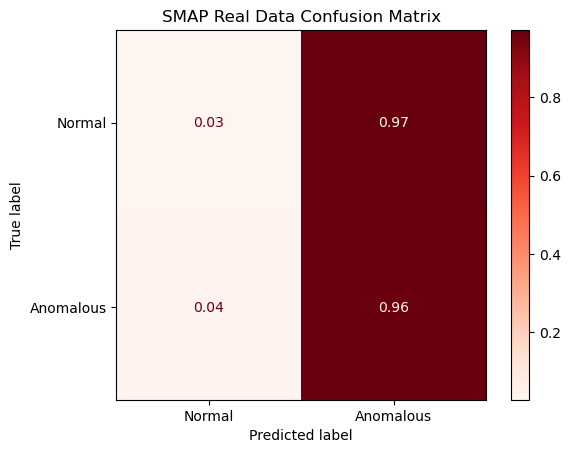

In [69]:
# Calculate CM
smap_conf_matrix = confusion_matrix(smap_label_test_data, combined_model_predictions)

# Normalize the confusion matrix by row 
smap_conf_matrix_norm = smap_conf_matrix.astype('float') / smap_conf_matrix.sum(axis=1)[:, np.newaxis]

# Display CM
smap_disp_r = ConfusionMatrixDisplay(confusion_matrix=smap_conf_matrix_norm, 
                              display_labels=["Normal", "Anomalous"])
smap_disp_r.plot(cmap="Reds", values_format=".2f") 
plt.title("SMAP Real Data Confusion Matrix")
plt.show()


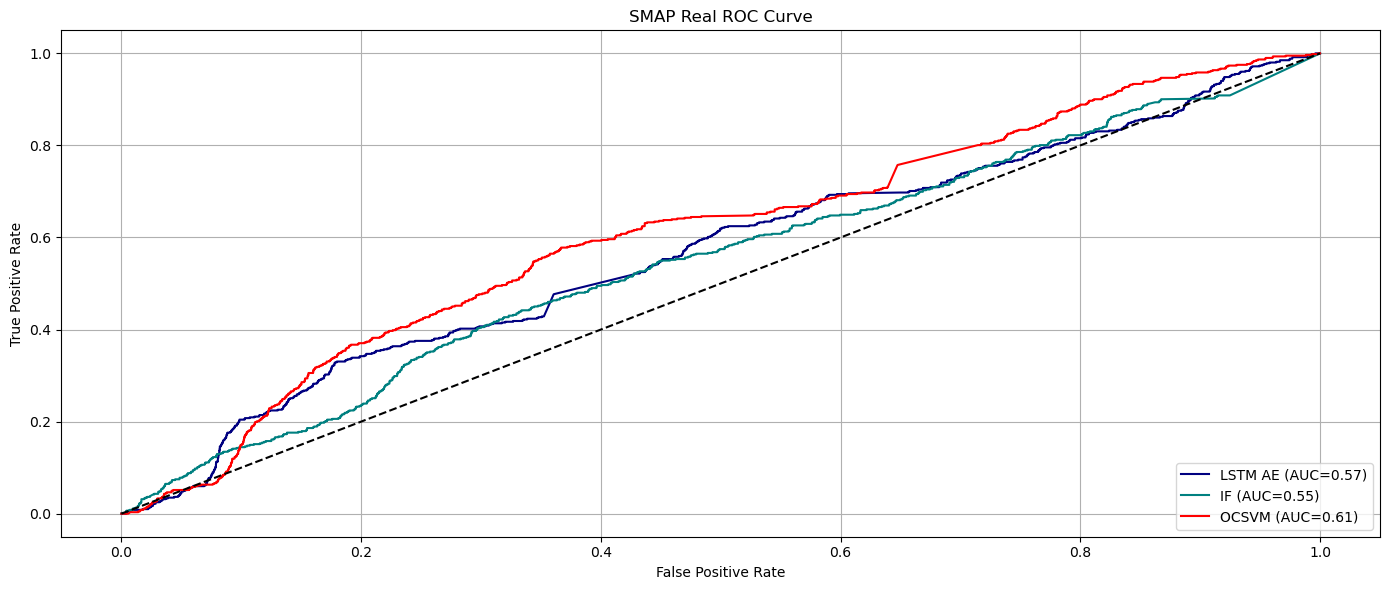

In [70]:
# Get anomaly scores 
lstm_ae_scores = smap_lstm_test_mse 
if_scores = -isolation_forest.decision_function(smap_feature_test_data)  
oc_scores = -one_class_svm.decision_function(smap_feature_test_data) 

# Truth labels
test_labels = np.array(smap_label_test_data)

# LSTM Autoencoder
fp_lstm, tp_lstm, _ = roc_curve(test_labels, lstm_ae_scores)
roc_auc_lstm = auc(fp_lstm, tp_lstm)

# Isolation Forest
fp_if, tp_if, _ = roc_curve(test_labels, if_scores)
roc_auc_if = auc(fp_if, tp_if)

# One-Class SVM
fp_oc, tp_oc, _ = roc_curve(test_labels, oc_scores)
roc_auc_oc = auc(fp_oc, tp_oc)

plt.figure(figsize=(14, 6))

# ROC Curve
plt.plot(fp_lstm, tp_lstm, label=f"LSTM AE (AUC={roc_auc_lstm:.2f})", color="navy")
plt.plot(fp_if, tp_if, label=f"IF (AUC={roc_auc_if:.2f})", color="teal")
plt.plot(fp_oc, tp_oc, label=f"OCSVM (AUC={roc_auc_oc:.2f})", color="red")
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SMAP Real ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

In [71]:
# Use different threshold for LSTM AE 

lstm_ae_threshold = [80, 90, 95]
for th in lstm_ae_threshold:
    th_new = np.percentile(smap_train_mse, th)
    predict_lstm = [1 if err > th_new else 0 for err in smap_lstm_test_mse]

    p = precision_score(smap_label_test_data, predict_lstm)
    r = recall_score(smap_label_test_data, predict_lstm)
    f = f1_score(smap_label_test_data, predict_lstm)
    
    print(f"Threshold parameter: {th}, LSTM AE Precision: {p}, LSTM AE Recall: {r}, LSTM AE F1 Score: {f}")
    
print(" ")

# Use different settings for IF
cont_param = [0.05, 0.1]

for cont_new in cont_param:
        model_if = IsolationForest(contamination=cont_new, max_samples=0.25, random_state=42)
        model_if.fit(smap_feature_train_data)
        if_test_predict = model_if.predict(smap_feature_test_data)
        predict_if = [0 if pred == 1 else 1 for pred in if_test_predict]

        p = precision_score(smap_label_test_data, predict_if)
        r = recall_score(smap_label_test_data, predict_if)
        f = f1_score(smap_label_test_data, predict_if)

        print(f"IF Contamination parameter: {cont_new}, IF Precision: {p},IF Recall: {r},IF F1 Score: {f}")
        
print(" ")

# Use different settings for OCSVM
nu_param = [0.05, 0.2]

for nu_new in nu_param:
        oc_svm_model = OneClassSVM(nu=nu_new, kernel="rbf", gamma=0.33)
        oc_svm_model.fit(smap_feature_train_data)
        oc_test_predict = oc_svm_model.predict(smap_feature_test_data)
        predict_oc = [0 if pred == 1 else 1 for pred in oc_test_predict] 
        
        p = precision_score(smap_label_test_data, predict_oc)
        r = recall_score(smap_label_test_data, predict_oc)
        f = f1_score(smap_label_test_data, predict_oc)

        print(f"OCSVM Nu parameter: {nu_new}, OCSVM Precision: {p}, OCSVM Recall: {r}, OCSVM F1 Score: {f}")

Threshold parameter: 80, LSTM AE Precision: 0.10646572678658241, LSTM AE Recall: 0.3637873754152824, LSTM AE F1 Score: 0.16472358029334339
Threshold parameter: 90, LSTM AE Precision: 0.11627906976744186, LSTM AE Recall: 0.22425249169435216, LSTM AE F1 Score: 0.15314804310833804
Threshold parameter: 95, LSTM AE Precision: 0.11848958333333333, LSTM AE Recall: 0.1511627906976744, LSTM AE F1 Score: 0.13284671532846715
 
IF Contamination parameter: 0.05, IF Precision: 0.10276073619631902,IF Recall: 0.11129568106312292,IF F1 Score: 0.10685805422647528
IF Contamination parameter: 0.1, IF Precision: 0.08129543952412426,IF Recall: 0.20431893687707642,IF F1 Score: 0.11631205673758865
 
OCSVM Nu parameter: 0.05, OCSVM Precision: 0.08584686774941995, OCSVM Recall: 0.061461794019933555, OCSVM F1 Score: 0.07163601161665054
OCSVM Nu parameter: 0.2, OCSVM Precision: 0.11989528795811519, OCSVM Recall: 0.3803986710963455, OCSVM F1 Score: 0.1823248407643312


# Explainable AI (XAI) Implementation

In [72]:
# SHAP explainer for One-Class SVM
ocsvm_subset = shap.sample(smap_feature_train_data, 100)
ocsvm_explainer = shap.KernelExplainer(one_class_svm.predict, ocsvm_subset)
shap_ocsvm = ocsvm_explainer.shap_values(smap_feature_test_data[:50]) 


# SHAP explainer for Isolation Forest
iforest_explainer = shap.TreeExplainer(isolation_forest)
shap_iforest = iforest_explainer.shap_values(smap_feature_test_data)


# LSTM Autoencoder with explainer
def reconstruction_err(input_data):
    lstm_ip = input_data.reshape((-1, 1, 3))  
    predictions = lstm_ae.predict(lstm_ip)
    error = np.mean(np.square(lstm_ip - predictions), axis=(1, 2))
    return error

lstm_subset = smap_feature_train_data[:100]
lstm_explainer = shap.KernelExplainer(reconstruction_err, lstm_subset)

shap_lstm = lstm_explainer.shap_values(smap_feature_test_data[:50]) 

  0%|          | 0/50 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 

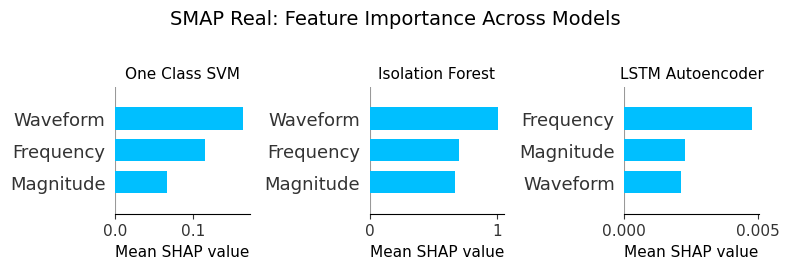

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

# One-Class SVM
plt.sca(ax[0])
shap.summary_plot(shap_ocsvm, smap_feature_test_data[:50], feature_names=spacecraft_features, plot_type="bar", color="deepskyblue", show=False)
ax[0].set_title("One Class SVM", fontsize=11)

# Isolation Forest
plt.sca(ax[1])
shap.summary_plot(shap_iforest, smap_feature_test_data, feature_names=spacecraft_features, plot_type="bar", color="deepskyblue", show=False)
ax[1].set_title("Isolation Forest", fontsize=11)

# LSTM Autoencoder
plt.sca(ax[2])
shap.summary_plot(shap_lstm, smap_feature_test_data[:50], feature_names=spacecraft_features, plot_type="bar", color="deepskyblue", show=False)
ax[2].set_title("LSTM Autoencoder", fontsize=11)

# Hide individual x-tick labels
for a in ax:
    a.set_xlabel("Mean SHAP value", fontsize=11)  

# Main Title and Layout Adjustments
plt.suptitle("SMAP Real: Feature Importance Across Models", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

# SMAP Real + CGAN Synthetic Anomalies (Combined Data)

In [74]:
# Get synthetic anomalies using noise
anomaly_count = len(smap_feature_train_data) 

# Timesteps and features for input shape
time_steps = 1 
features = smap_feature_train_data.shape[1] 

# Get synthetic anomalies and scale to match training data scale
synthetic_anomaly = smap_generate_synthetic_anomalies(anomaly_count, smap_feature_train_data.shape[1:])
synthetic_anomaly_scaled = scaler.transform(synthetic_anomaly.reshape(anomaly_count, -1)).reshape(anomaly_count, smap_feature_train_data.shape[1],1)

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step


In [75]:
# Reshape real and synthetic data
smap_feature_train_expanded = smap_feature_train_data.reshape(-1, time_steps, features)
synthetic_anomaly_data = synthetic_anomaly_scaled.reshape(-1, time_steps, features)

In [76]:
synthetic_anomaly_data.shape

(2661, 1, 3)

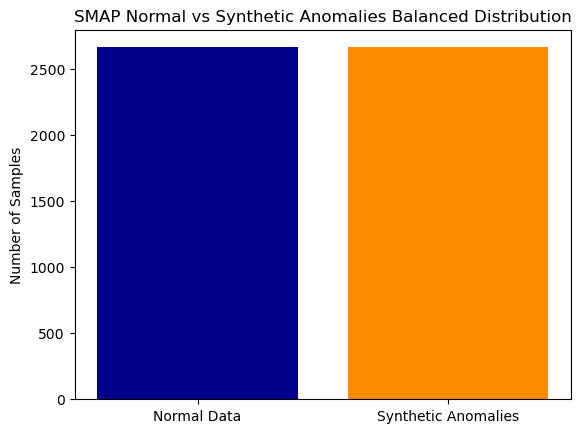

In [77]:
# Normal data & Synthetic anomalies
normal_samples_count = smap_feature_train_expanded.shape[0]
synthetic_anomaly_count = synthetic_anomaly_data.shape[0]

# Show plot
categories = ['Normal Data', 'Synthetic Anomalies']
counts = [normal_samples_count, synthetic_anomaly_count]

plt.bar(categories, counts, color=['darkblue', 'darkorange'])
plt.title('SMAP Normal vs Synthetic Anomalies Balanced Distribution')
plt.ylabel('Number of Samples')
plt.show()

In [78]:
synthetic_anomaly_count

2661

In [79]:
normal_samples_count

2661

In [80]:
# Combine the data
smap_combined_data = np.vstack([smap_feature_train_expanded, synthetic_anomaly_data])

In [81]:
smap_combined_data.shape

(5322, 1, 3)

In [82]:
# LSTM Autoencoder
def build_lstm_ae(time_steps, features):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=(time_steps, features)))
    model.add(Dropout(0.4))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dropout(0.4))
    model.add(RepeatVector(time_steps))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(features)))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model


# Build the autoencoder
lstm_ae = build_lstm_ae(time_steps, features)

# Get model summary
lstm_ae.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 1, 128)         │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 3)           │           195 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,443 (458.76 KB)

 Trainable params: 117,443 (458.76 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
history = lstm_ae.fit(smap_combined_data, smap_combined_data, epochs=50, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.6308 - val_loss: 3.1776
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5965 - val_loss: 3.0427
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5128 - val_loss: 2.6187
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2368 - val_loss: 1.1171
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5563 - val_loss: 0.2488
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3751 - val_loss: 0.1987
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2825 - val_loss: 0.1970
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2310 - val_loss: 0.1828
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2336 - val_loss: 0.1763
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2208 - val_loss: 0.1708
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2239 - val_loss: 0.1657
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2134 - val_lo

In [84]:
smap_feature_train_expanded

array([[[0.58461328, 0.6635556 , 0.72702385]],

       [[0.57449499, 0.47049964, 0.76521356]],

       [[0.57126802, 0.54265938, 0.73392399]],

       ...,

       [[0.72171571, 0.3536357 , 0.51710163]],

       [[0.84136531, 0.5563291 , 0.51175621]],

       [[0.85295212, 0.22529912, 0.50641079]]])

In [85]:
smap_combined_data

array([[[ 0.58461328,  0.6635556 ,  0.72702385]],

       [[ 0.57449499,  0.47049964,  0.76521356]],

       [[ 0.57126802,  0.54265938,  0.73392399]],

       ...,

       [[-0.12458916,  0.37336308, -2.86386466]],

       [[-0.11364792,  0.40492839, -2.84157395]],

       [[-0.8867929 , -0.09777965, -3.50061488]]])

In [86]:
# Set the threshold and evaluate on test data
smap_combined_predictions = lstm_ae.predict(smap_combined_data)
smap_combined_mse = np.mean(np.square(smap_combined_data - smap_combined_predictions), axis=(1, 2))
smap_combined_threshold = np.percentile(smap_combined_mse,85)
print("Anomaly Detection Threshold:", smap_combined_threshold)

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Anomaly Detection Threshold: 0.03627957541718137


In [87]:
# Reshape test data for prediction
smap_lstm_combined_test = smap_feature_test_data.reshape(-1, time_steps, features)
smap_combined_test_predictions = lstm_ae.predict(smap_lstm_combined_test)
smap_combined_test_mse = np.mean(np.square(smap_lstm_combined_test - smap_combined_test_predictions), axis=(1, 2))

272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step


In [88]:
# Flatten combined data
smap_combined_data_balanced = smap_combined_data.reshape(smap_combined_data.shape[0], -1) 

In [89]:
smap_combined_data_balanced.shape

(5322, 3)

In [90]:
smap_combined_data_balanced

array([[ 0.58461328,  0.6635556 ,  0.72702385],
       [ 0.57449499,  0.47049964,  0.76521356],
       [ 0.57126802,  0.54265938,  0.73392399],
       ...,
       [-0.12458916,  0.37336308, -2.86386466],
       [-0.11364792,  0.40492839, -2.84157395],
       [-0.8867929 , -0.09777965, -3.50061488]])

In [91]:
# Train IF 
isolation_forest = IsolationForest(contamination=0.01, max_samples= 0.25, random_state=42)
isolation_forest.fit(smap_combined_data_balanced)

# Train OCSVM 
one_class_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.33)
one_class_svm.fit(smap_combined_data_balanced)

# Get predictions from the LSTM Autoencoder
smap_lstm_comb_predictions = [1 if error > smap_combined_threshold else 0 for error in smap_combined_test_mse]

# Get predictions from the Isolation Forest
smap_if_comb_test_predict = isolation_forest.predict(smap_feature_test_data)
# Convert Isolation Forest output (-1 for anomaly, 1 for normal) to 0 and 1
smap_if_comb_test_predictions = [0 if pred == -1 else 1 for pred in smap_if_comb_test_predict]

# Get predictions from the One-Class SVM
smap_svm_comb_test_predict = one_class_svm.predict(smap_feature_test_data)
# Convert One-Class SVM output (-1 for anomaly, 1 for normal) to 0 and 1
smap_svm_comb_test_predictions = [0 if pred == -1 else 1 for pred in smap_svm_comb_test_predict]

In [92]:
# Evaluate LSTM Autoencoder
precision = precision_score(smap_label_test_data, smap_lstm_comb_predictions)
recall = recall_score(smap_label_test_data, smap_lstm_comb_predictions)
f1 = f1_score(smap_label_test_data, smap_lstm_comb_predictions)
print(f"LSTM AE: Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

# Evaluate Isolation Forest
precision = precision_score(smap_label_test_data, smap_if_comb_test_predictions)
recall = recall_score(smap_label_test_data, smap_if_comb_test_predictions)
f1 = f1_score(smap_label_test_data, smap_if_comb_test_predictions)
print(f"Isolation Forest: Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

# Evaluate One-Class SVM
precision = precision_score(smap_label_test_data, smap_svm_comb_test_predictions)
recall = recall_score(smap_label_test_data, smap_svm_comb_test_predictions)
f1 = f1_score(smap_label_test_data, smap_svm_comb_test_predictions)
print(f"One-Class SVM: Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

LSTM AE: Precision: 0.11829134720700986, Recall: 0.3588039867109635, F1 Score: 0.17792421746293247

Isolation Forest: Precision: 0.0693354868481772, Recall: 0.9983388704318937, F1 Score: 0.1296655879180151

One-Class SVM: Precision: 0.06639323250448603, Recall: 0.8604651162790697, F1 Score: 0.12327463112803427



In [93]:
# Combine predictions using majority voting
smap_combined_predictions = []
for lstm, iforest, ocsvm in zip(smap_lstm_comb_predictions, smap_if_comb_test_predictions, smap_svm_comb_test_predictions):
    smap_combined_predictions.append(1 if (lstm + iforest + ocsvm) >= 2 else 0)

# Evaluate the combined predictions
smap_comb_recall = recall_score(smap_label_test_data, smap_combined_predictions)
smap_comb_f1 = f1_score(smap_label_test_data, smap_combined_predictions)
smap_comb_precision = precision_score(smap_label_test_data, smap_combined_predictions)

print(f"SMAP Real and CGAN Synthetic Anomalies Recall: {round(smap_comb_recall,2)}")
print(f"SMAP Real and CGAN Synthetic Anomalies F1 Score: {round(smap_comb_f1,2)}")
print(f"SMAP Real and CGAN Synthetic Anomalies Precision: {round(smap_comb_precision,2)}")

SMAP Real and CGAN Synthetic Anomalies Recall: 0.98
SMAP Real and CGAN Synthetic Anomalies F1 Score: 0.13
SMAP Real and CGAN Synthetic Anomalies Precision: 0.07


In [94]:
# Classification Report
print("\nSMAP Real and CGAN:")
print(classification_report(smap_label_test_data, smap_combined_predictions))


SMAP Real and CGAN:
              precision    recall  f1-score   support

           0       0.88      0.01      0.03      8071
           1       0.07      0.98      0.13       602

    accuracy                           0.08      8673
   macro avg       0.48      0.49      0.08      8673
weighted avg       0.83      0.08      0.03      8673



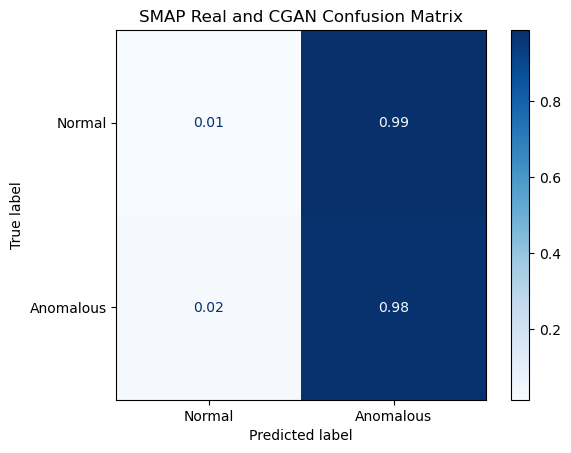

In [95]:
# Calculate CM
cf_smap = confusion_matrix(smap_label_test_data, smap_combined_predictions)

# Normalize CM by row 
smap_comb_conf_matrix = cf_smap.astype('float') / cf_smap.sum(axis=1)[:, np.newaxis]

# Plot CM
smap_display = ConfusionMatrixDisplay(confusion_matrix=smap_comb_conf_matrix, 
                              display_labels=["Normal", "Anomalous"])
smap_display.plot(cmap="Blues", values_format=".2f")  
plt.title("SMAP Real and CGAN Confusion Matrix")
plt.show()

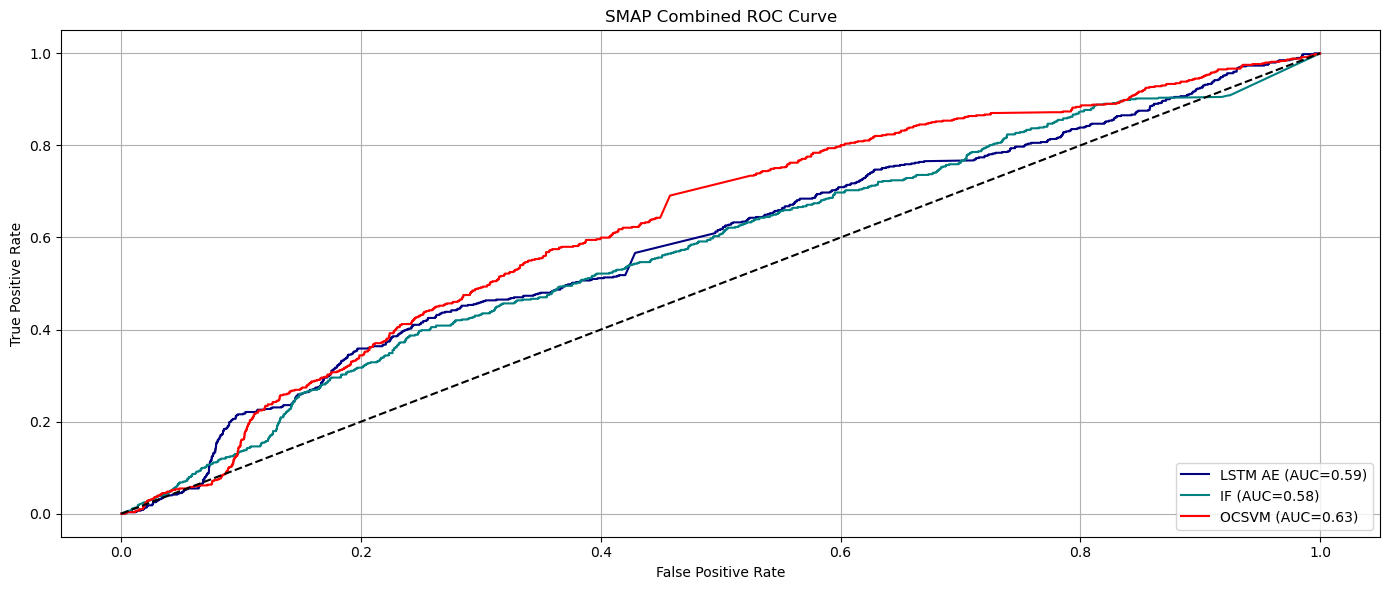

In [96]:
# Get anomaly scores 
lstm_ae_scores = smap_combined_test_mse 
if_scores = -isolation_forest.decision_function(smap_feature_test_data)  
oc_scores = -one_class_svm.decision_function(smap_feature_test_data) 

# Truth labels
test_labels = np.array(smap_label_test_data)

# LSTM Autoencoder
fp_lstm, tp_lstm, _ = roc_curve(test_labels, lstm_ae_scores)
roc_auc_lstm = auc(fp_lstm, tp_lstm)

# Isolation Forest
fp_if, tp_if, _ = roc_curve(test_labels, if_scores)
roc_auc_if = auc(fp_if, tp_if)

# One-Class SVM
fp_oc, tp_oc, _ = roc_curve(test_labels, oc_scores)
roc_auc_oc = auc(fp_oc, tp_oc)

plt.figure(figsize=(14, 6))

# ROC Curve
plt.plot(fp_lstm, tp_lstm, label=f"LSTM AE (AUC={roc_auc_lstm:.2f})", color="navy")
plt.plot(fp_if, tp_if, label=f"IF (AUC={roc_auc_if:.2f})", color="teal")
plt.plot(fp_oc, tp_oc, label=f"OCSVM (AUC={roc_auc_oc:.2f})", color="red")
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SMAP Combined ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

In [97]:
# Use different threshold for LSTM AE 

lstm_ae_threshold = [80, 90, 95]
for th in lstm_ae_threshold:
    th_new = np.percentile(smap_combined_mse, th)
    predict_lstm = [1 if err > th_new else 0 for err in smap_combined_test_mse]

    p = precision_score(smap_label_test_data, predict_lstm)
    r = recall_score(smap_label_test_data, predict_lstm)
    f = f1_score(smap_label_test_data, predict_lstm)
    
    print(f"Threshold parameter: {th}, LSTM AE Precision: {p}, LSTM AE Recall: {r}, LSTM AE F1 Score: {f}")
    
print(" ")

# Use different settings for IF
cont_param = [0.05, 0.1]

for cont_new in cont_param:
        model_if = IsolationForest(contamination=cont_new, max_samples=0.25, random_state=42)
        model_if.fit(smap_combined_data_balanced)
        if_test_predict = model_if.predict(smap_feature_test_data)
        predict_if = [0 if pred == 1 else 1 for pred in if_test_predict]

        p = precision_score(smap_label_test_data, predict_if)
        r = recall_score(smap_label_test_data, predict_if)
        f = f1_score(smap_label_test_data, predict_if)

        print(f"IF Contamination parameter: {cont_new}, IF Precision: {p},IF Recall: {r},IF F1 Score: {f}")

print(" ")

# Use different settings for OCSVM
nu_param = [0.05, 0.2]

for nu_new in nu_param:
        oc_svm_model = OneClassSVM(nu=nu_new, kernel="rbf", gamma=0.33)
        oc_svm_model.fit(smap_combined_data_balanced)
        oc_test_predict = oc_svm_model.predict(smap_feature_test_data)
        predict_oc = [0 if pred == 1 else 1 for pred in oc_test_predict] 
        
        p = precision_score(smap_label_test_data, predict_oc)
        r = recall_score(smap_label_test_data, predict_oc)
        f = f1_score(smap_label_test_data, predict_oc)

        print(f"OCSVM Nu parameter: {nu_new}, OCSVM Precision: {p}, OCSVM Recall: {r}, OCSVM F1 Score: {f}")

Threshold parameter: 80, LSTM AE Precision: 0.10574257425742574, LSTM AE Recall: 0.4435215946843854, LSTM AE F1 Score: 0.17077070674768147
Threshold parameter: 90, LSTM AE Precision: 0.11451612903225807, LSTM AE Recall: 0.23588039867109634, LSTM AE F1 Score: 0.15418023887079263
Threshold parameter: 95, LSTM AE Precision: 0.07855973813420622, LSTM AE Recall: 0.07973421926910298, LSTM AE F1 Score: 0.07914262159934048
 
IF Contamination parameter: 0.05, IF Precision: 0.08214285714285714,IF Recall: 0.03820598006644518,IF F1 Score: 0.05215419501133787
IF Contamination parameter: 0.1, IF Precision: 0.09282178217821782,IF Recall: 0.12458471760797342,IF F1 Score: 0.10638297872340424
 
OCSVM Nu parameter: 0.05, OCSVM Precision: 0.08759124087591241, OCSVM Recall: 0.03986710963455149, OCSVM F1 Score: 0.05479452054794521
OCSVM Nu parameter: 0.2, OCSVM Precision: 0.11721366376423309, OCSVM Recall: 0.29069767441860467, OCSVM F1 Score: 0.16706443914081145


# Explainable AI (XAI) Implementation

In [98]:
# SHAP explainer for Isolation Forest
iforest_explainer = shap.TreeExplainer(isolation_forest)
shap_iforest = iforest_explainer.shap_values(smap_feature_test_data)

# LSTM Autoencoder with explainer
def reconstruction_err(input_data):
    input_data_new = input_data.reshape((-1, 1, 3))
    predict_re = lstm_ae.predict(input_data_new)
    error = np.mean(np.square(input_data_new - predict_re), axis=(1, 2))
    return error
 
# Subset of 100
lstm_subset = smap_combined_data_balanced[:100]  
lstm_explainer = shap.KernelExplainer(reconstruction_err, lstm_subset)

# Sample size with 50
shap_lstm = lstm_explainer.shap_values(smap_feature_test_data[:50])  

# SHAP explainer for One-Class SVM
ocsvm_subset = shap.sample(smap_combined_data_balanced, 100)
ocsvm_explainer = shap.KernelExplainer(one_class_svm.predict, ocsvm_subset)
shap_ocsvm = ocsvm_explainer.shap_values(smap_feature_test_data[:50]) 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/50 [00:00<?, ?it/s]

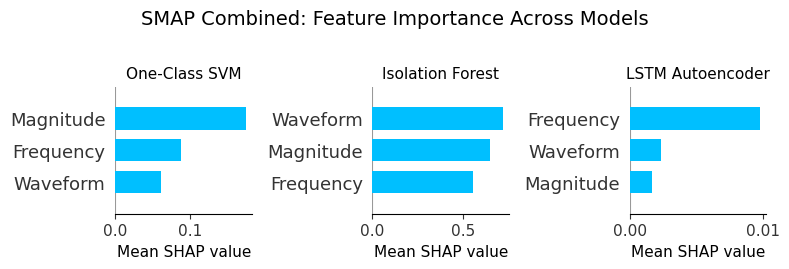

In [99]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

# One-Class SVM
plt.sca(ax[0])
shap.summary_plot(shap_ocsvm, smap_feature_test_data[:50], feature_names=spacecraft_features, plot_type="bar", color="deepskyblue", show=False)
ax[0].set_title("One-Class SVM", fontsize=11)

# Isolation Forest
plt.sca(ax[1])
shap.summary_plot(shap_iforest, smap_feature_test_data, feature_names=spacecraft_features, plot_type="bar", color="deepskyblue", show=False)
ax[1].set_title("Isolation Forest", fontsize=11)

# LSTM Autoencoder
plt.sca(ax[2])
shap.summary_plot(shap_lstm, smap_feature_test_data[:50], feature_names=spacecraft_features, plot_type="bar", color="deepskyblue", show=False)
ax[2].set_title("LSTM Autoencoder", fontsize=11)

# Hide individual x-tick labels
for a in ax:
    a.set_xlabel("Mean SHAP value", fontsize=11) 

# Show plot
plt.suptitle("SMAP Combined: Feature Importance Across Models", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

# MSL Set Up

# Test Set Counts

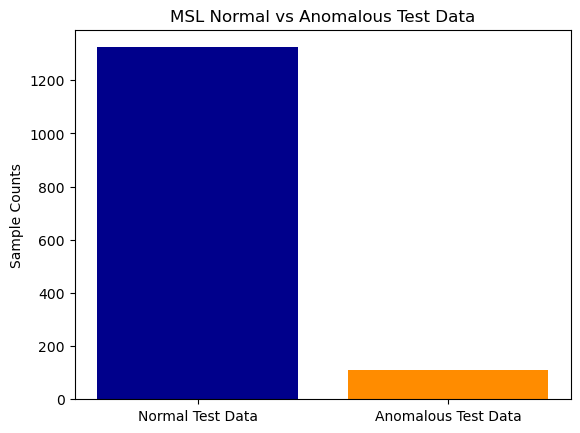

In [100]:
# Anomalies in the test set
normal_test_data = msl_feature_test_data[msl_label_test_data == 0]
anomalous_test_data = msl_feature_test_data[msl_label_test_data == 1]

normal_count = normal_test_data.shape[0]
anomaly_count = anomalous_test_data.shape[0]

# Show plot
categories = ['Normal Test Data', 'Anomalous Test Data']
counts = [normal_count, anomaly_count]

plt.bar(categories, counts, color=['darkblue', 'darkorange'])
plt.title('MSL Normal vs Anomalous Test Data')
plt.ylabel('Sample Counts')
plt.show()

# CGAN - Train Model 

In [101]:
# Input shape based on training data's feature shape
input_shape = (msl_feature_train_data.shape[1], 1)

generator = build_generator_cgan(input_shape)
generator.summary()

discriminator = build_discriminator_cgan(input_shape)
discriminator.summary()

# Build GAN
gan = build_cgan_framework(generator, discriminator)
gan.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3)         │          6 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 3, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 3, 1)      │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 3, 2)      │          0 │ input_layer_8[0]… │
│ (Concatenate)       │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 3, 80)     │     26,560 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 3, 80)     │          0 │ lstm_10[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 3, 80)     │          0 │ leaky_re_lu_4[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 80)     │        320 │ dropout_10[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 80)        │     51,520 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 80)        │          0 │ lstm_11[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 80)        │          0 │ leaky_re_lu_5[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80)        │        320 │ dropout_11[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │        243 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 3, 1)      │          0 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 78,969 (308.47 KB)

 Trainable params: 78,649 (307.22 KB)

 Non-trainable params: 320 (1.25 KB)

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 3)         │          6 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 3, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 3, 1)      │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 3, 2)      │          0 │ input_layer_10[0… │
│ (Concatenate)       │                   │            │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 3, 80)     │     26,560 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 3, 80)     │          0 │ lstm_12[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 3, 80)     │          0 │ leaky_re_lu_6[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 80)     │        320 │ dropout_12[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 80)        │     51,520 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 80)        │          0 │ lstm_13[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 80)        │          0 │ leaky_re_lu_7[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80)        │        320 │ dropout_13[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         81 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 78,807 (307.84 KB)

 Trainable params: 78,487 (306.59 KB)

 Non-trainable params: 320 (1.25 KB)

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 3, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_19       │ (None, 3, 1)      │     78,969 │ input_layer_12[0… │
│ (Functional)        │                   │            │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_20       │ (None, 1)         │     78,807 │ functional_19[0]… │
│ (Functional)        │                   │            │ input_layer_13[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 157,776 (616.31 KB)

 Trainable params: 78,649 (307.22 KB)

 Non-trainable params: 79,127 (309.09 KB)

In [102]:
# Lists to track losses
d_losses = []  # Discriminator losses
g_losses = []  # Generator losses

def msl_generate_synthetic_anomalies(data_sample, input_shape):
# Noise parameters to create realistic anomalies (modify to adjust mean and standard deviation)
    shift_factor = 0.1  
    scale_factor = 0.8   
    
    # Get noise with mean and standard deviation (main parameters)
    mean = 0 + shift_factor
    std = 1 * scale_factor
    
    np.random.seed(42)
    noise = np.random.normal(mean, std, (data_sample, input_shape[0], 1))
    return generator.predict([noise, np.ones((data_sample, 1))])


def train_cgan_msl(generator, discriminator, gan, normal_data, epochs, batch_size):

    shift_factor = 0.1  
    scale_factor = 0.8  

    half_batch = batch_size // 2
    
    for epoch in range(epochs):
        np.random.seed(42)  # Set the seed before the sampling
        random_idx = np.random.randint(0, normal_data.shape[0], half_batch)
        real_samples = normal_data[random_idx].reshape(half_batch, normal_data.shape[1], 1)
        real_labels = np.ones((half_batch, 1))  # Label normal data as 1
        real_conditions = np.zeros((half_batch, 1))  # Condition 0 for normal data

        # Get synthetic anomalies
        synthetic_samples = msl_generate_synthetic_anomalies(half_batch, normal_data.shape[1:])
        synthetic_samples = scaler.transform(synthetic_samples.reshape(half_batch, -1)).reshape(half_batch, normal_data.shape[1], 1)
        synthetic_labels = np.zeros((half_batch, 1))  # Label synthetic data as 0
        synthetic_conditions = np.ones((half_batch, 1))  # Condition 1 for synthetic anomalies

        # Discriminator Training on both real and synthetic data
        loss_real_d = discriminator.train_on_batch([real_samples, real_conditions], real_labels)
        loss_fake_d = discriminator.train_on_batch([synthetic_samples, synthetic_conditions], synthetic_labels)
        loss_d = 0.5 * np.add(loss_real_d, loss_fake_d)

        # Train Generator
        noise = np.random.normal(shift_factor, scale_factor, (batch_size, normal_data.shape[1], 1))
        # Generator tricks discriminator
        fake_labels = np.ones((batch_size, 1))  
        loss_g = gan.train_on_batch([noise, np.ones((batch_size, 1))], fake_labels)
        loss_avg_g = np.mean(loss_g)

        # Track losses and evaluation metrics
        d_losses.append(loss_d[0])
        g_losses.append(loss_avg_g)

        # Losses per 10 epochs 
        if epoch % 10 == 0:
            print(f"Loss per Epochs: {epoch}, D: {loss_d[0]}, G: {loss_g}")
            
    return d_losses, g_losses

In [103]:
start_time = time.time()

scaler = StandardScaler().fit(msl_feature_train_data)

# CGAN Training Settings
epochs = 100
batch_size = 32
half_batch = batch_size // 2

# Execute training 
msl_d_loss, msl_g_loss = train_cgan_msl(generator, discriminator, gan, msl_feature_train_data, epochs, batch_size)

end_time = time.time()

# CGAN training time
total_time = end_time - start_time

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Loss per Epochs: 0, D: 0.6919535398483276, G: [array(0.68994987, dtype=float32), array(0.68994987, dtype=float32), array(0.46875, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Loss per Epochs: 10, D: 0.690960705280304, G: [array(0.69101113, dtype=float32), array(0.69101113, dtype=float32), array(0.4744318, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1

In [104]:
# Training time in seconds
print(f"MSL CGAN training time: {total_time:.2f} seconds")

MSL CGAN training time: 59.13 seconds


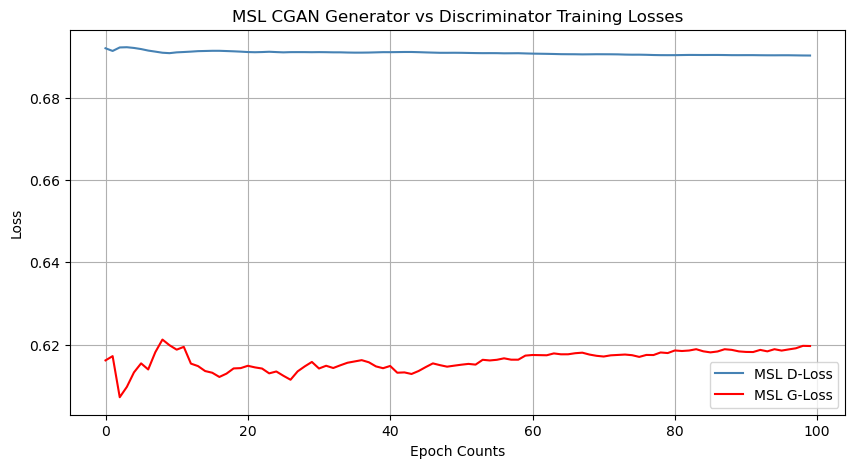

In [105]:
# Plot CGAN losses
def plot_cgan_msl_losses(msl_d_loss, msl_g_loss, title):
    plt.figure(figsize=(10, 5))
    plt.plot(msl_d_loss, label="MSL D-Loss", color='steelblue')
    plt.plot(msl_g_loss, label="MSL G-Loss", color='red')
    plt.title(title)
    plt.xlabel("Epoch Counts")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Loss data
plot_cgan_msl_losses(msl_d_loss, msl_g_loss, title="MSL CGAN Generator vs Discriminator Training Losses")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


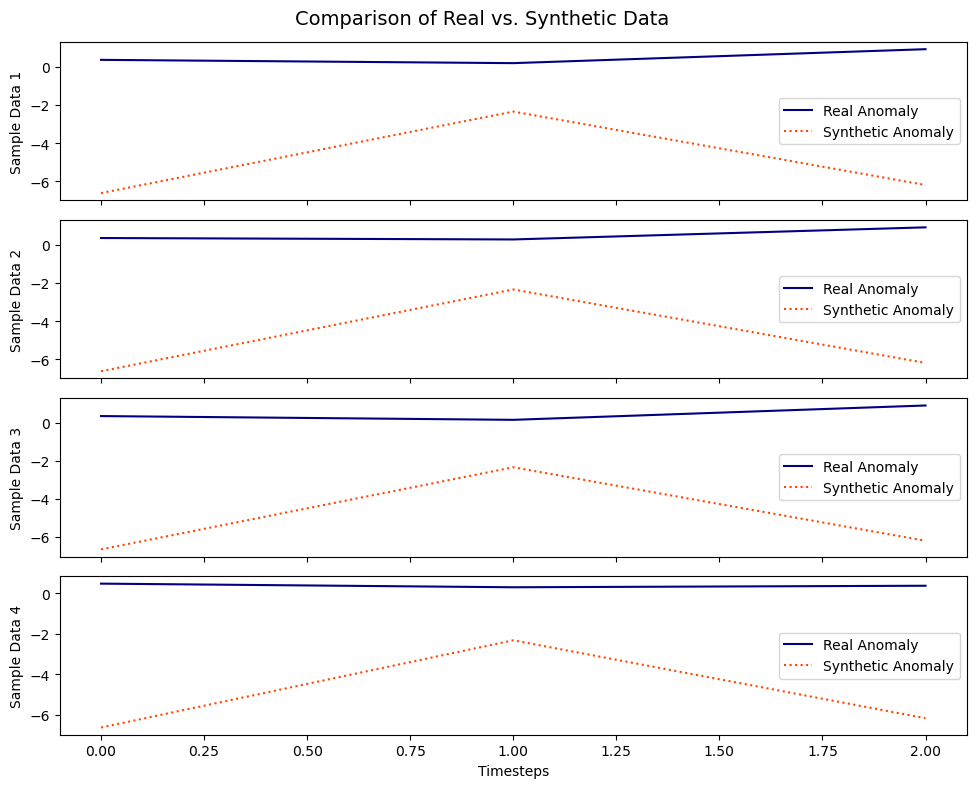

MSL DTW Distance between Real and Synthetic Anomalies: 66.22932183534103


In [106]:
# Number of synthetic samples to generate for visualization
samples = 4 

# Get synthetic anomalies and scale to match training data 
msl_synthetic_anomalies = msl_generate_synthetic_anomalies(samples, msl_feature_train_data.shape[1:])
msl_synthetic_anomalies_data = scaler.transform(msl_synthetic_anomalies.reshape(samples, -1)).reshape(samples, msl_feature_train_data.shape[1])

# Get real test anomalies for comparison
test_anomalies_data = msl_feature_test_data[msl_label_test_data == 1]
sample_data = test_anomalies_data[:samples]  

# Show plot
fig, axes = plt.subplots(samples, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Comparison of Real vs. Synthetic Data', fontsize=14)

for sample in range(samples):
    axes[sample].plot(sample_data[sample].flatten(), label="Real Anomaly", color="navy")
    axes[sample].plot(msl_synthetic_anomalies_data[sample].flatten(), label="Synthetic Anomaly", color="orangered", linestyle=":")
    axes[sample].legend()
    axes[sample].set_ylabel(f"Sample Data {sample+1}")

plt.xlabel("Timesteps")
plt.tight_layout()
plt.show()

# Calculate DTW for samples comparison
synthetic_data = msl_synthetic_anomalies_data.reshape(-1)
real_test_data = sample_data.reshape(-1)  

msl_dtw_distance, _ = fastdtw(real_test_data, synthetic_data)

print(f"MSL DTW Distance between Real and Synthetic Anomalies: {msl_dtw_distance}")

# MSL Real Data

In [107]:
# LSTM Autoencoder to capture temporal patterns
def build_lstm_ae(time_steps, features):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=(time_steps,features)))
    model.add(Dropout(0.4))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dropout(0.4))
    model.add(RepeatVector(time_steps))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(features)))
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model


# Input shape
time_steps, features = 1, msl_feature_train_data.shape[1]

# Build the autoencoder
lstm_ae = build_lstm_ae(time_steps, features)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [108]:
# Reshape data for LSTM 
msl_lstm_train_data = msl_feature_train_data.reshape(msl_feature_train_data.shape[0], time_steps, features)

history = lstm_ae.fit(msl_lstm_train_data, msl_lstm_train_data, epochs=50, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2213 - val_loss: 0.2890
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2062 - val_loss: 0.2669
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1868 - val_loss: 0.2339
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1574 - val_loss: 0.1794
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1115 - val_loss: 0.0945
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0525 - val_loss: 0.0152
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - val_loss: 0.0056
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175 - val_loss: 0.0100
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 - val_loss: 0.0071
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179 - val_loss: 0.0076
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - val_loss: 0.0066
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 - val_l

In [109]:
# Get reconstruction errors on the training set
msl_train_predict = lstm_ae.predict(msl_lstm_train_data)
msl_train_mse = np.mean(np.square(msl_lstm_train_data - msl_train_predict), axis=(1, 2))

# Set the threshold of training errors
msl_lstm_threshold = np.percentile(msl_train_mse, 80)

print("Train mse:", msl_train_mse)
print("Anomaly Detection Threshold:", msl_lstm_threshold)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 
Train mse: [0.00305845 0.00288937 0.00175544 ... 0.00197557 0.00377089 0.00122761]
Anomaly Detection Threshold: 0.005790520189213912


In [110]:
# Reshape the balanced test data for LSTM
msl_lstm_test_data = msl_feature_test_data.reshape(msl_feature_test_data.shape[0], time_steps,features)

print("Balanced Test Data Shape:", msl_lstm_test_data.shape)

# Predict on the balanced test set
msl_test_predict = lstm_ae.predict(msl_lstm_test_data)

Balanced Test Data Shape: (1436, 1, 3)
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step


In [111]:
# Train IF 
isolation_forest = IsolationForest(contamination=0.01,max_samples = 0.25, random_state=42)
isolation_forest.fit(msl_feature_train_data)

# Train OCSVM 
one_class_svm = OneClassSVM(nu=0.2, kernel="rbf", gamma=0.33)
one_class_svm.fit(msl_feature_train_data)

# Get LSTM reconstruction errors 
msl_lstm_test_mse = np.mean(np.square(msl_lstm_test_data - msl_test_predict), axis=(1, 2))
# Get predictions from the LSTM Autoencoder
msl_lstm_test_predictions = [1 if error > msl_lstm_threshold else 0 for error in msl_lstm_test_mse]

# Get predictions from the Isolation Forest
msl_iforest_test_predict = isolation_forest.predict(msl_feature_test_data)
# Convert Isolation Forest output (-1 for anomaly, 1 for normal) to 0 and 1
msl_iforest_test_predictions = [0 if pred == -1 else 1 for pred in msl_iforest_test_predict]

# Get predictions from the One-Class SVM
msl_svm_test_predict = one_class_svm.predict(msl_feature_test_data)
# Convert One-Class SVM output (-1 for anomaly, 1 for normal) to 0 and 1
msl_svm_test_predictions = [0 if pred == -1 else 1 for pred in msl_svm_test_predict]

In [112]:
# Evaluate LSTM Autoencoder
precision = precision_score(msl_label_test_data, msl_lstm_test_predictions)
recall = recall_score(msl_label_test_data, msl_lstm_test_predictions)
f1 = f1_score(msl_label_test_data, msl_lstm_test_predictions)
print(f"LSTM AE: Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

# Evaluate Isolation Forest
precision = precision_score(msl_label_test_data, msl_iforest_test_predictions)
recall = recall_score(msl_label_test_data, msl_iforest_test_predictions)
f1 = f1_score(msl_label_test_data, msl_iforest_test_predictions)
print(f"Isolation Forest: Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

# Evaluate One-Class SVM
precision = precision_score(msl_label_test_data, msl_svm_test_predictions)
recall = recall_score(msl_label_test_data, msl_svm_test_predictions)
f1 = f1_score(msl_label_test_data, msl_svm_test_predictions)
print(f"One-Class SVM: Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

LSTM AE: Precision: 0.07349665924276169, Recall: 0.29464285714285715, F1 Score: 0.11764705882352942

Isolation Forest: Precision: 0.07726597325408618, Recall: 0.9285714285714286, F1 Score: 0.14266117969821676

One-Class SVM: Precision: 0.07611798287345385, Recall: 0.7142857142857143, F1 Score: 0.13757523645743766



In [113]:
# Combine predictions using majority voting
combined_model_predictions = []
for lstm,iforest,svm in zip(msl_lstm_test_predictions, msl_iforest_test_predictions, msl_svm_test_predictions):
    combined_model_predictions.append(1 if (lstm + iforest + svm) >= 2 else 0)

# Evaluate the combined predictions
msl_real_recall = recall_score(msl_label_test_data, combined_model_predictions)
msl_real_f1 = f1_score(msl_label_test_data, combined_model_predictions)
msl_real_precision = precision_score(msl_label_test_data, combined_model_predictions)

print(f"MSL Real Data Recall: {round(msl_real_recall,2)}")
print(f"MSL Real Data F1 Score: {round(msl_real_f1,2)}")
print(f"MSL Real Data Precision: {round(msl_real_precision,2)}")

MSL Real Data Recall: 0.87
MSL Real Data F1 Score: 0.14
MSL Real Data Precision: 0.08


In [114]:
# Classification Report
print("\nMSL Real:")
print(classification_report(msl_label_test_data, combined_model_predictions))


MSL Real:
              precision    recall  f1-score   support

           0       0.92      0.14      0.24      1324
           1       0.08      0.87      0.14       112

    accuracy                           0.19      1436
   macro avg       0.50      0.50      0.19      1436
weighted avg       0.86      0.19      0.23      1436



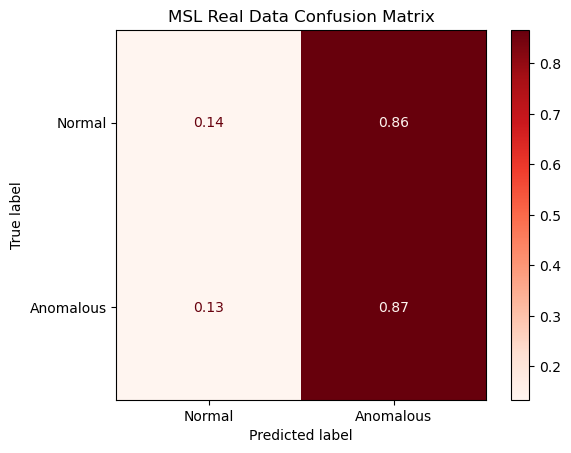

In [115]:
# Calculate CM
msl_conf_matrix = confusion_matrix(msl_label_test_data, combined_model_predictions)

# Normalize the confusion matrix by row 
msl_conf_matrix_norm = msl_conf_matrix.astype('float') / msl_conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot CM
msl_disp_r = ConfusionMatrixDisplay(confusion_matrix=msl_conf_matrix_norm, 
                              display_labels=["Normal", "Anomalous"])
msl_disp_r.plot(cmap="Reds", values_format=".2f")  # Adjust format for percentages
plt.title("MSL Real Data Confusion Matrix")
plt.show()

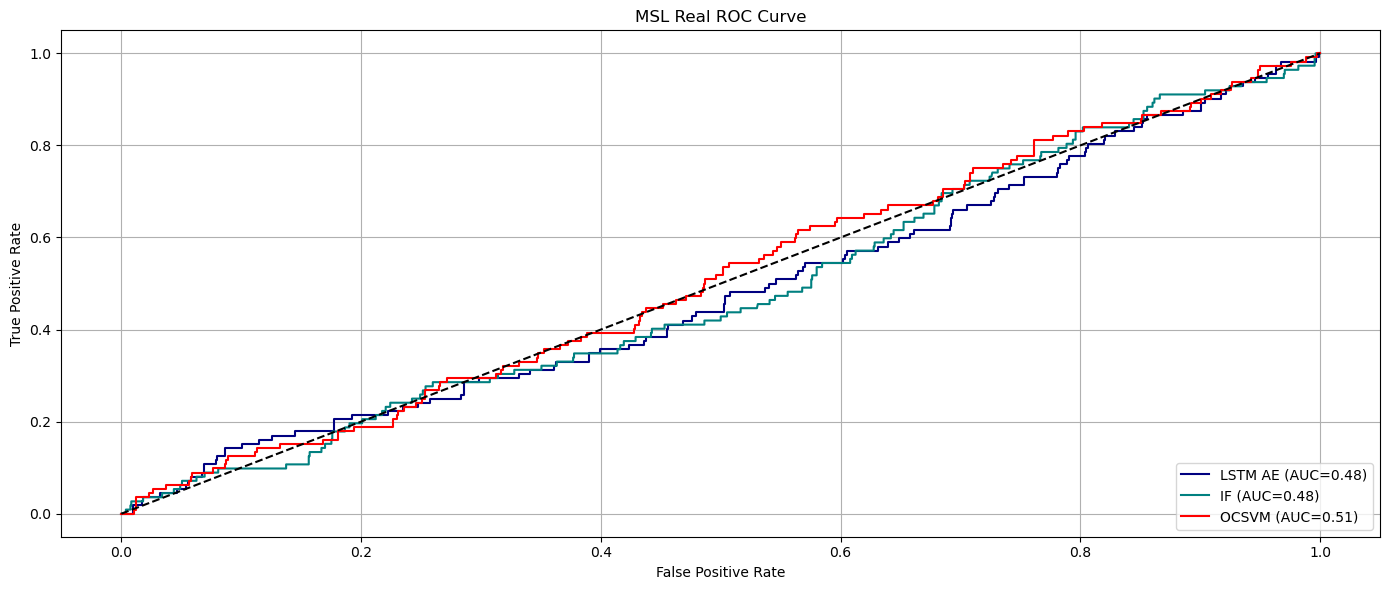

In [116]:
# Anomaly scores 
lstm_ae_scores = msl_lstm_test_mse  
if_scores = -isolation_forest.decision_function(msl_feature_test_data) 
oc_scores = -one_class_svm.decision_function(msl_feature_test_data) 

# Truth labels
test_labels = np.array(msl_label_test_data)  

# LSTM Autoencoder
fp_lstm, tp_lstm, _ = roc_curve(test_labels, lstm_ae_scores)
roc_auc_lstm = auc(fp_lstm, tp_lstm)

# Isolation Forest
fp_if, tp_if, _ = roc_curve(test_labels, if_scores)
roc_auc_if = auc(fp_if, tp_if)

# One-Class SVM
fp_oc, tp_oc, _ = roc_curve(test_labels, oc_scores)
roc_auc_svm = auc(fp_oc, tp_oc)

# ROC curves
plt.figure(figsize=(14, 6))
plt.plot(fp_lstm, tp_lstm, label=f"LSTM AE (AUC={roc_auc_lstm:.2f})", color="navy")
plt.plot(fp_if, tp_if, label=f"IF (AUC={roc_auc_if:.2f})", color="teal")
plt.plot(fp_oc, tp_oc, label=f"OCSVM (AUC={roc_auc_svm:.2f})", color="red")
plt.plot([0, 1], [0, 1], color="black", linestyle="--") 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MSL Real ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

In [117]:
# Use different threshold for LSTM AE 

lstm_ae_threshold = [85, 90, 95]
for th in lstm_ae_threshold:
    th_new = np.percentile(msl_train_mse, th)
    predict_lstm = [1 if err > th_new else 0 for err in msl_lstm_test_mse]

    p = precision_score(msl_label_test_data, predict_lstm)
    r = recall_score(msl_label_test_data, predict_lstm)
    f = f1_score(msl_label_test_data, predict_lstm)
    
    print(f"Threshold parameter: {th}, LSTM AE Precision: {p}, LSTM AE Recall: {r}, LSTM AE F1 Score: {f}")
    
print(" ")

# Use different settings for IF
cont_param = [0.05, 0.1]

for cont_new in cont_param:
        model_if = IsolationForest(contamination=cont_new, max_samples=0.25, random_state=42)
        model_if.fit(msl_feature_train_data)
        if_test_predict = model_if.predict(msl_feature_test_data)
        predict_if = [0 if pred == 1 else 1 for pred in if_test_predict]

        p = precision_score(msl_label_test_data, predict_if)
        r = recall_score(msl_label_test_data, predict_if)
        f = f1_score(msl_label_test_data, predict_if)

        print(f"IF Contamination parameter: {cont_new}, IF Precision: {p},IF Recall: {r},IF F1 Score: {f}")

print(" ")

# Use different settings for OCSVM
nu_param = [0.05, 0.1]

for nu_new in nu_param:
        oc_svm_model = OneClassSVM(nu=nu_new, kernel="rbf", gamma=0.33)
        oc_svm_model.fit(msl_feature_train_data)
        oc_test_predict = oc_svm_model.predict(msl_feature_test_data)
        predict_oc = [0 if pred == 1 else 1 for pred in oc_test_predict] 
        
        p = precision_score(msl_label_test_data, predict_oc)
        r = recall_score(msl_label_test_data, predict_oc)
        f = f1_score(msl_label_test_data, predict_oc)

        print(f"OCSVM Nu parameter: {nu_new}, OCSVM Precision: {p}, OCSVM Recall: {r}, OCSVM F1 Score: {f}")

Threshold parameter: 85, LSTM AE Precision: 0.07427055702917772, LSTM AE Recall: 0.25, LSTM AE F1 Score: 0.11451942740286297
Threshold parameter: 90, LSTM AE Precision: 0.08421052631578947, LSTM AE Recall: 0.21428571428571427, LSTM AE F1 Score: 0.12090680100755666
Threshold parameter: 95, LSTM AE Precision: 0.10227272727272728, LSTM AE Recall: 0.16071428571428573, LSTM AE F1 Score: 0.12500000000000003
 
IF Contamination parameter: 0.05, IF Precision: 0.06334841628959276,IF Recall: 0.125,IF F1 Score: 0.08408408408408408
IF Contamination parameter: 0.1, IF Precision: 0.07741935483870968,IF Recall: 0.21428571428571427,IF F1 Score: 0.11374407582938388
 
OCSVM Nu parameter: 0.05, OCSVM Precision: 0.09714285714285714, OCSVM Recall: 0.15178571428571427, OCSVM F1 Score: 0.11846689895470382
OCSVM Nu parameter: 0.1, OCSVM Precision: 0.07913669064748201, OCSVM Recall: 0.19642857142857142, OCSVM F1 Score: 0.11282051282051282


# Explainable AI (XAI) Implementation

In [118]:
# SHAP explainer for One-Class SVM
ocsvm_subset = shap.sample(msl_feature_train_data, 100)
ocsvm_explainer = shap.KernelExplainer(one_class_svm.predict, ocsvm_subset)
shap_ocsvm = ocsvm_explainer.shap_values(msl_feature_test_data[:50]) 


# SHAP explainer for Isolation Forest
iforest_explainer = shap.TreeExplainer(isolation_forest)
shap_iforest = iforest_explainer.shap_values(msl_feature_test_data)


# SHAP explainer for LSTM Autoencoder 
def reconstruction_err(input_data):
    lstm_ip = input_data.reshape((-1, 1, 3)) 
    predictions = lstm_ae.predict(lstm_ip)
    error = np.mean(np.square(lstm_ip - predictions), axis=(1, 2))
    return error

lstm_subset = msl_feature_train_data[:100]  
lstm_explainer = shap.KernelExplainer(reconstruction_err, lstm_subset)

shap_lstm = lstm_explainer.shap_values(msl_feature_test_data[:50]) 

  0%|          | 0/50 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s

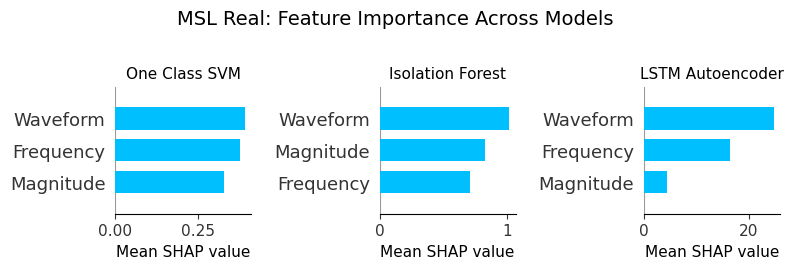

In [119]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

# One-Class SVM
plt.sca(ax[0])
shap.summary_plot(shap_ocsvm, msl_feature_test_data[:50], feature_names=spacecraft_features, plot_type="bar", color="deepskyblue", show=False)
ax[0].set_title("One Class SVM", fontsize=11)

# Isolation Forest
plt.sca(ax[1])
shap.summary_plot(shap_iforest, msl_feature_test_data, feature_names=spacecraft_features, plot_type="bar", color="deepskyblue", show=False)
ax[1].set_title("Isolation Forest", fontsize=11)

# LSTM Autoencoder
plt.sca(ax[2])
shap.summary_plot(shap_lstm, msl_feature_test_data[:50], feature_names=spacecraft_features, plot_type="bar", color="deepskyblue", show=False)
ax[2].set_title("LSTM Autoencoder", fontsize=11)

# Hide individual x-tick labels
for a in ax:
    a.set_xlabel("Mean SHAP value", fontsize=11) 

# Show plot
plt.suptitle("MSL Real: Feature Importance Across Models", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

# MSL Real + CGAN Synthetic Anomalies (Combined Data)

In [120]:
# Get synthetic anomalies using noise
anomaly_count = len(msl_feature_train_data) 

# Timesteps and features for input shape
time_steps = 1 
features = msl_feature_train_data.shape[1] 

# Get synthetic anomalies and scale to match training data 
synthetic_anomaly = msl_generate_synthetic_anomalies(anomaly_count, msl_feature_train_data.shape[1:])
synthetic_anomaly_scaled = scaler.transform(synthetic_anomaly.reshape(anomaly_count, -1)).reshape(anomaly_count, msl_feature_train_data.shape[1],1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [121]:
# Reshape real and synthetic data
msl_feature_train_expanded = msl_feature_train_data.reshape(-1, time_steps, features)
synthetic_anomaly_data = synthetic_anomaly_scaled.reshape(-1, time_steps, features)

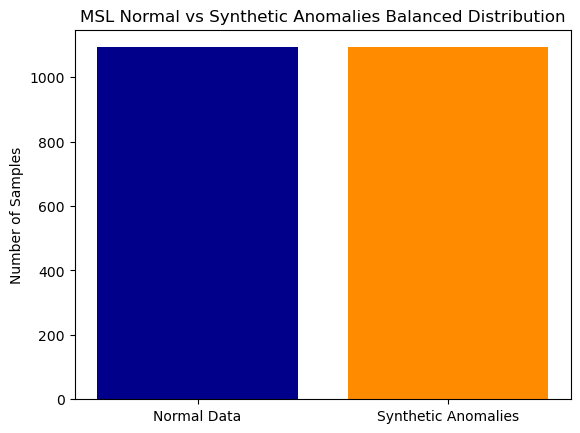

In [122]:
# Normal data & Synthetic anomalies
normal_samples_count = msl_feature_train_expanded.shape[0]
synthetic_anomaly_count = synthetic_anomaly_data.shape[0]

# Show plot
categories = ['Normal Data', 'Synthetic Anomalies']
counts = [normal_samples_count, synthetic_anomaly_count]

plt.bar(categories, counts, color=['darkblue', 'darkorange'])
plt.title('MSL Normal vs Synthetic Anomalies Balanced Distribution')
plt.ylabel('Number of Samples')
plt.show()

In [123]:
# Combine the balanced data
msl_combined_data = np.vstack([msl_feature_train_expanded, synthetic_anomaly_data])

In [124]:
# LSTM Autoencoder
def build_lstm_ae(time_steps, features):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=(time_steps, features)))
    model.add(Dropout(0.4))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dropout(0.4))
    model.add(RepeatVector(time_steps))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(features)))
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

# Build the autoencoder 
lstm_ae = build_lstm_ae(time_steps, features)

# Get model summary
lstm_ae.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 1, 128)         │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 1, 3)           │           195 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,443 (458.76 KB)

 Trainable params: 117,443 (458.76 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
history = lstm_ae.fit(msl_combined_data, msl_combined_data, epochs=50, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 12.9028 - val_loss: 28.2975
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.0699 - val_loss: 15.0292
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3167 - val_loss: 2.5622
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1827 - val_loss: 0.5648
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0166 - val_loss: 0.3504
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6403 - val_loss: 0.5762
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5640 - val_loss: 0.5123
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3577 - val_loss: 0.1415
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2605 - val_loss: 0.1678
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1002 - val_loss: 0.1728
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9955 - val_loss: 0.0866
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8484 - va

In [126]:
# Set the threshold and evaluate on test data
msl_combined_predictions = lstm_ae.predict(msl_combined_data)
msl_combined_mse = np.mean(np.square(msl_combined_data - msl_combined_predictions), axis=(1, 2))
msl_combined_threshold = np.percentile(msl_combined_mse, 80)
print("Anomaly Detection Threshold:", msl_combined_threshold)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Anomaly Detection Threshold: 0.007047028834806236


In [127]:
# Reshape test data for prediction
msl_lstm_combined_test = msl_feature_test_data.reshape(-1, time_steps, features)
msl_combined_test_predictions = lstm_ae.predict(msl_lstm_combined_test)
msl_combined_test_mse = np.mean(np.square(msl_lstm_combined_test - msl_combined_test_predictions), axis=(1, 2))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step


In [128]:
# Flatten combined data
msl_combined_data_balanced = msl_combined_data.reshape(msl_combined_data.shape[0], -1) 

In [129]:
# Train IF 
isolation_forest = IsolationForest(contamination=0.01,max_samples = 0.25,random_state=42)
isolation_forest.fit(msl_combined_data_balanced)

# Train OCSVM 
one_class_svm = OneClassSVM(nu=0.2, kernel="rbf", gamma=0.33)
one_class_svm.fit(msl_combined_data_balanced)

# Get predictions from the LSTM Autoencoder
msl_lstm_comb_predictions = [1 if error > msl_combined_threshold else 0 for error in msl_combined_test_mse]

# Get predictions from the Isolation Forest
msl_if_comb_test_predict = isolation_forest.predict(msl_feature_test_data)
# Convert Isolation Forest output (-1 for anomaly, 1 for normal) to 0 and 1
msl_if_comb_test_predictions = [0 if pred == -1 else 1 for pred in msl_if_comb_test_predict]

# Get predictions from the One-Class SVM
msl_svm_comb_test_predict = one_class_svm.predict(msl_feature_test_data)
# Convert One-Class SVM output (-1 for anomaly, 1 for normal) to 0 and 1
msl_svm_comb_test_predictions = [0 if pred == -1 else 1 for pred in msl_svm_comb_test_predict]

In [130]:
# Evaluate LSTM Autoencoder
precision = precision_score(msl_label_test_data, msl_lstm_comb_predictions)
recall = recall_score(msl_label_test_data, msl_lstm_comb_predictions)
f1 = f1_score(msl_label_test_data, msl_lstm_comb_predictions)
print(f"LSTM AE: Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

# Evaluate Isolation Forest
precision = precision_score(msl_label_test_data, msl_if_comb_test_predictions)
recall = recall_score(msl_label_test_data, msl_if_comb_test_predictions)
f1 = f1_score(msl_label_test_data, msl_if_comb_test_predictions)
print(f"Isolation Forest: Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

# Evaluate One-Class SVM
precision = precision_score(msl_label_test_data, msl_svm_comb_test_predictions)
recall = recall_score(msl_label_test_data, msl_svm_comb_test_predictions)
f1 = f1_score(msl_label_test_data, msl_svm_comb_test_predictions)
print(f"One-Class SVM: Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

LSTM AE: Precision: 0.07434944237918216, Recall: 0.35714285714285715, F1 Score: 0.12307692307692307

Isolation Forest: Precision: 0.07631954350927246, Recall: 0.9553571428571429, F1 Score: 0.1413474240422721

One-Class SVM: Precision: 0.07648183556405354, Recall: 0.7142857142857143, F1 Score: 0.1381692573402418



In [131]:
# Combine predictions using majority voting
msl_combined_predictions = []
for lstm, iforest, ocsvm in zip(msl_lstm_comb_predictions, msl_if_comb_test_predictions, msl_svm_comb_test_predictions):
    msl_combined_predictions.append(1 if (lstm + iforest + ocsvm) >= 2 else 0)

# Evaluate the combined predictions
msl_comb_recall = recall_score(msl_label_test_data, msl_combined_predictions)
msl_comb_f1 = f1_score(msl_label_test_data, msl_combined_predictions)
msl_comb_precision = precision_score(msl_label_test_data, msl_combined_predictions)

print(f"MSL Real and CGAN Synthetic Anomalies Recall: {round(msl_comb_recall,2)}")
print(f"MSL Real and CGAN Synthetic Anomalies F1 Score: {round(msl_comb_f1,2)}")
print(f"MSL Real and CGAN Synthetic Anomalies Precision: {round(msl_comb_precision,2)}")

MSL Real and CGAN Synthetic Anomalies Recall: 0.89
MSL Real and CGAN Synthetic Anomalies F1 Score: 0.14
MSL Real and CGAN Synthetic Anomalies Precision: 0.08


In [132]:
# Classification Report
print("\nMSL Real and CGAN:")
print(classification_report(msl_label_test_data, msl_combined_predictions))


MSL Real and CGAN:
              precision    recall  f1-score   support

           0       0.91      0.09      0.17      1324
           1       0.08      0.89      0.14       112

    accuracy                           0.15      1436
   macro avg       0.49      0.49      0.15      1436
weighted avg       0.84      0.15      0.16      1436



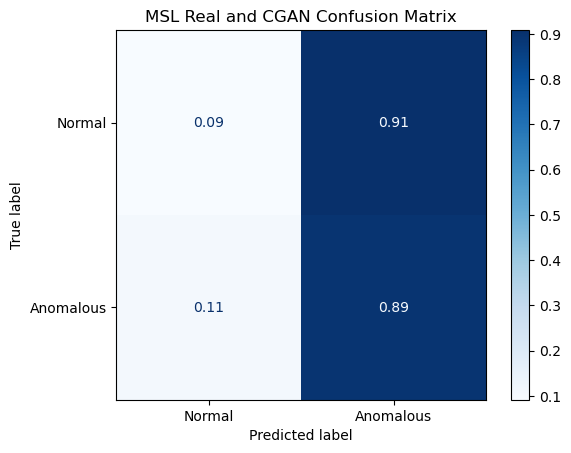

In [133]:
# Plot CM
msl_conf_matrix = confusion_matrix(msl_label_test_data, msl_combined_predictions)

# Normalize the confusion matrix by row
msl_conf_matrix_norm = msl_conf_matrix.astype('float') / msl_conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot CM
msl_display = ConfusionMatrixDisplay(confusion_matrix=msl_conf_matrix_norm, 
                              display_labels=["Normal", "Anomalous"])
msl_display.plot(cmap="Blues", values_format=".2f") 
plt.title("MSL Real and CGAN Confusion Matrix")
plt.show()

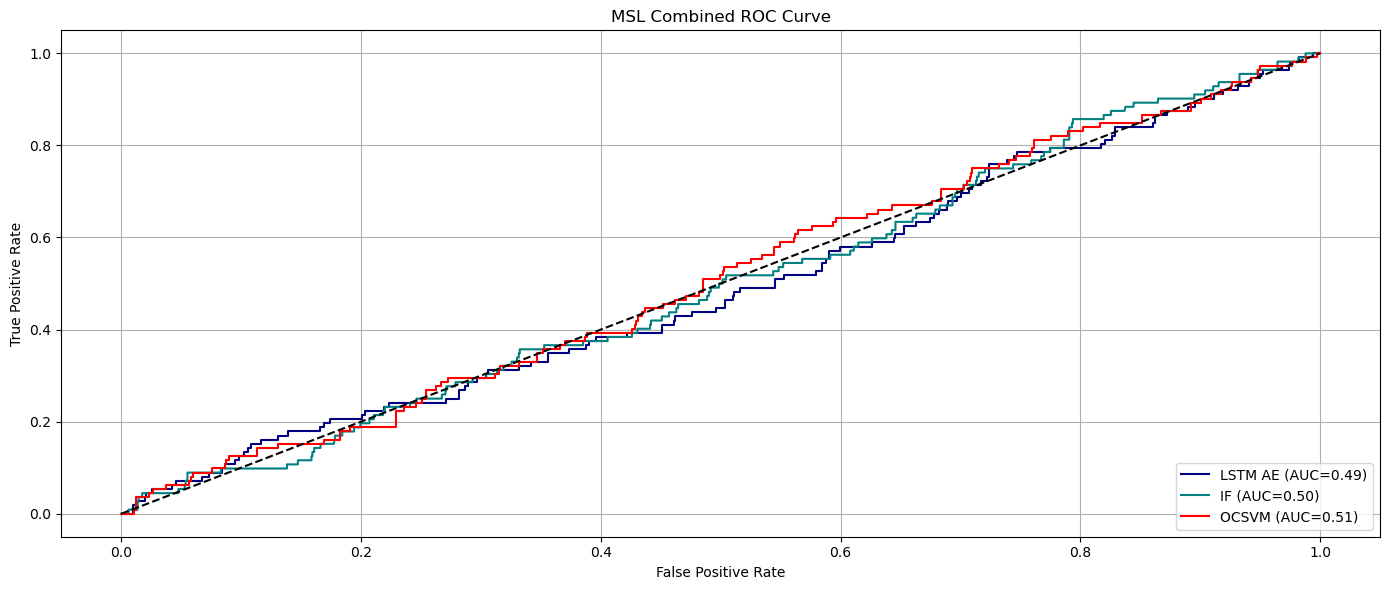

In [134]:
# Anomaly scores 
lstm_ae_scores = msl_combined_test_mse  
if_scores = -isolation_forest.decision_function(msl_feature_test_data) 
oc_scores = -one_class_svm.decision_function(msl_feature_test_data) 

# Truth labels
test_labels = np.array(msl_label_test_data)  

# LSTM Autoencoder
fp_lstm, tp_lstm, _ = roc_curve(test_labels, lstm_ae_scores)
roc_auc_lstm = auc(fp_lstm, tp_lstm)

# Isolation Forest
fp_if, tp_if, _ = roc_curve(test_labels, if_scores)
roc_auc_if = auc(fp_if, tp_if)

# One-Class SVM
fp_oc, tp_oc, _ = roc_curve(test_labels, oc_scores)
roc_auc_svm = auc(fp_oc, tp_oc)

# ROC curves
plt.figure(figsize=(14, 6))

# ROC Curve
plt.plot(fp_lstm, tp_lstm, label=f"LSTM AE (AUC={roc_auc_lstm:.2f})", color="navy")
plt.plot(fp_if, tp_if, label=f"IF (AUC={roc_auc_if:.2f})", color="teal")
plt.plot(fp_oc, tp_oc, label=f"OCSVM (AUC={roc_auc_svm:.2f})", color="red")
plt.plot([0, 1], [0, 1], color="black", linestyle="--") 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MSL Combined ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

In [135]:
# Use different threshold for LSTM AE 

lstm_ae_threshold = [85, 90, 95]
for th in lstm_ae_threshold:
    th_new = np.percentile(msl_combined_mse, th)
    predict_lstm = [1 if err > th_new else 0 for err in msl_combined_test_mse]

    p = precision_score(msl_label_test_data, predict_lstm)
    r = recall_score(msl_label_test_data, predict_lstm)
    f = f1_score(msl_label_test_data, predict_lstm)
    
    print(f"Threshold parameter: {th}, LSTM AE Precision: {p}, LSTM AE Recall: {r}, LSTM AE F1 Score: {f}")
    
print(" ")

# Use different settings for IF
cont_param = [0.05, 0.1]

for cont_new in cont_param:
        model_if = IsolationForest(contamination=cont_new, max_samples=0.25, random_state=42)
        model_if.fit(msl_combined_data_balanced)
        if_test_predict = model_if.predict(msl_feature_test_data)
        predict_if = [0 if pred == 1 else 1 for pred in if_test_predict]

        p = precision_score(msl_label_test_data, predict_if)
        r = recall_score(msl_label_test_data, predict_if)
        f = f1_score(msl_label_test_data, predict_if)

        print(f"IF Contamination parameter: {cont_new}, IF Precision: {p},IF Recall: {r},IF F1 Score: {f}")
        
print(" ")

# Use different settings for OCSVM
nu_param = [0.05, 0.1]

for nu_new in nu_param:
        oc_svm_model = OneClassSVM(nu=nu_new, kernel="rbf", gamma=0.33)
        oc_svm_model.fit(msl_combined_data_balanced)
        oc_test_predict = oc_svm_model.predict(msl_feature_test_data)
        predict_oc = [0 if pred == 1 else 1 for pred in oc_test_predict] 
        
        p = precision_score(msl_label_test_data, predict_oc)
        r = recall_score(msl_label_test_data, predict_oc)
        f = f1_score(msl_label_test_data, predict_oc)

        print(f"OCSVM Nu parameter: {nu_new}, OCSVM Precision: {p}, OCSVM Recall: {r}, OCSVM F1 Score: {f}")

Threshold parameter: 85, LSTM AE Precision: 0.07847533632286996, LSTM AE Recall: 0.3125, LSTM AE F1 Score: 0.12544802867383514
Threshold parameter: 90, LSTM AE Precision: 0.07563025210084033, LSTM AE Recall: 0.24107142857142858, LSTM AE F1 Score: 0.11513859275053306
Threshold parameter: 95, LSTM AE Precision: 0.09359605911330049, LSTM AE Recall: 0.16964285714285715, LSTM AE F1 Score: 0.12063492063492062
 
IF Contamination parameter: 0.05, IF Precision: 0.06046511627906977,IF Recall: 0.11607142857142858,IF F1 Score: 0.07951070336391437
IF Contamination parameter: 0.1, IF Precision: 0.08150470219435736,IF Recall: 0.23214285714285715,IF F1 Score: 0.12064965197215777
 
OCSVM Nu parameter: 0.05, OCSVM Precision: 0.09714285714285714, OCSVM Recall: 0.15178571428571427, OCSVM F1 Score: 0.11846689895470382
OCSVM Nu parameter: 0.1, OCSVM Precision: 0.07829181494661921, OCSVM Recall: 0.19642857142857142, OCSVM F1 Score: 0.11195928753180662


# Explainable AI (XAI) Implementation

In [136]:
# SHAP explainer for Isolation Forest
iforest_explainer = shap.TreeExplainer(isolation_forest)
shap_iforest = iforest_explainer.shap_values(msl_feature_test_data)

# LSTM Autoencoder with explainer
def reconstruction_err(input_data):
    input_data_new = input_data.reshape((-1, 1, 3)) 
    predict_re = lstm_ae.predict(input_data_new)
    error = np.mean(np.square(input_data_new - predict_re), axis=(1, 2))
    return error

# Subset of 100
lstm_subset = msl_combined_data_balanced[:100]  
lstm_explainer = shap.KernelExplainer(reconstruction_err, lstm_subset)

# Sample size of 50
shap_lstm = lstm_explainer.shap_values(msl_feature_test_data[:50])  

# SHAP explainer for One-Class SVM
ocsvm_subset = shap.sample(msl_combined_data_balanced, 100)
ocsvm_explainer = shap.KernelExplainer(one_class_svm.predict, ocsvm_subset)
shap_ocsvm = ocsvm_explainer.shap_values(msl_feature_test_data[:50])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/50 [00:00<?, ?it/s]

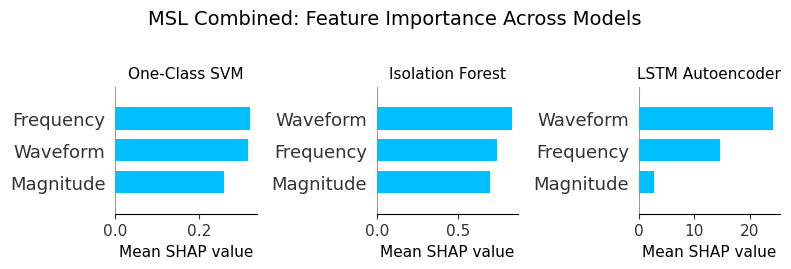

In [137]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

# One-Class SVM
plt.sca(ax[0])
shap.summary_plot(shap_ocsvm, msl_feature_test_data[:50], feature_names=spacecraft_features, plot_type="bar", color="deepskyblue", show=False)
ax[0].set_title("One-Class SVM", fontsize=11)

# Isolation Forest
plt.sca(ax[1])
shap.summary_plot(shap_iforest, msl_feature_test_data, feature_names=spacecraft_features, plot_type="bar", color="deepskyblue", show=False)
ax[1].set_title("Isolation Forest", fontsize=11)

# LSTM Autoencoder
plt.sca(ax[2])
shap.summary_plot(shap_lstm, msl_feature_test_data[:50], feature_names=spacecraft_features, plot_type="bar", color="deepskyblue", show=False)
ax[2].set_title("LSTM Autoencoder", fontsize=11)

# Hide individual x-tick labels
for a in ax:
    a.set_xlabel("Mean SHAP value", fontsize=11)  

# Show plot
plt.suptitle("MSL Combined: Feature Importance Across Models", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

# Final Comparison of Real Vs Combined Datasets

# SMAP Real Vs Combined Metrics

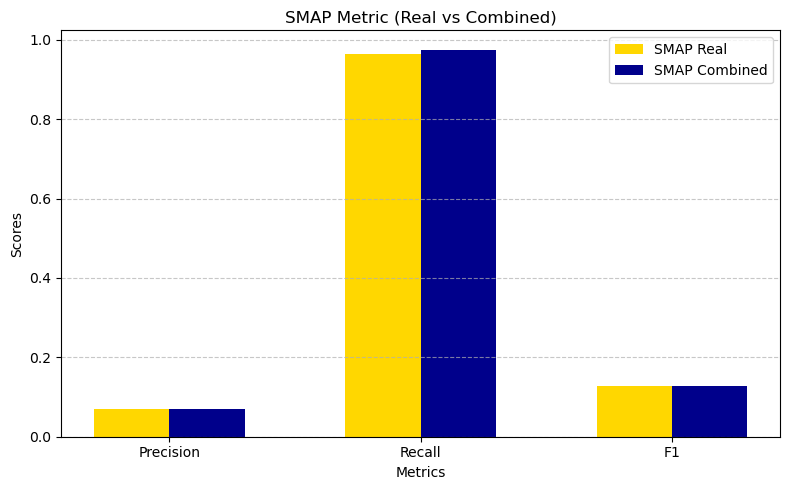

In [138]:
# Real metrics
smap_real_bp = [smap_real_precision, smap_real_recall, smap_real_f1] 
# Combined metrics
smap_combined_bp = [smap_comb_precision, smap_comb_recall, smap_comb_f1] 
metrics = ['Precision', 'Recall', 'F1']

x = np.arange(len(metrics))
width = 0.3  

fig, ax = plt.subplots(figsize=(8, 5))

# SMAP plot
rects1 = ax.bar(x - width/2, smap_real_bp, width, label='SMAP Real', color='gold')
rects2 = ax.bar(x + width/2, smap_combined_bp, width, label='SMAP Combined', color='darkblue')

# Labels, title and axes
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('SMAP Metric (Real vs Combined)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# MSL Real Vs Combined Metrics

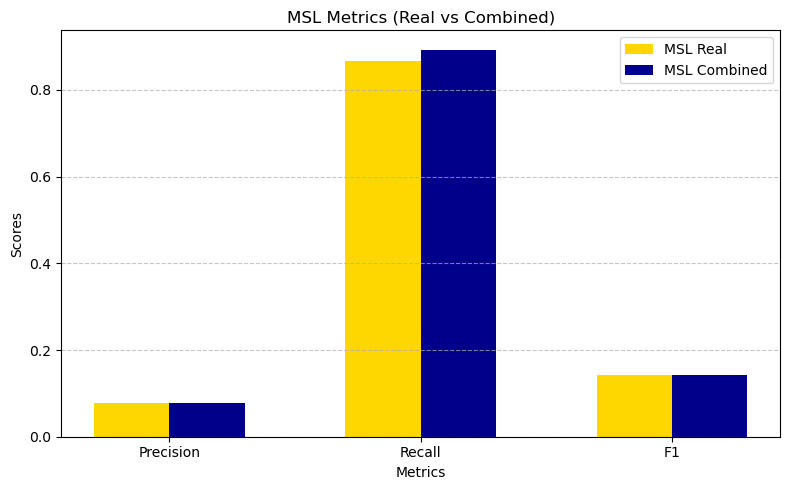

In [141]:
# Real metrics
msl_real_bp = [msl_real_precision, msl_real_recall, msl_real_f1] 
# Combined metrics
msl_combined_bp = [msl_comb_precision, msl_comb_recall, msl_comb_f1]
metrics = ['Precision', 'Recall', 'F1']

x = np.arange(len(metrics))
width = 0.3  

fig, ax = plt.subplots(figsize=(8, 5))

# MSL
rects1 = ax.bar(x - width/2, msl_real_bp, width, label='MSL Real', color='gold')
rects2 = ax.bar(x + width/2, msl_combined_bp, width, label='MSL Combined', color='darkblue')

# Labels, title and axes
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('MSL Metrics (Real vs Combined)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()